# Formation energy prediction

В данной работе мы повторим задачу прогнозирования энергии образования из первой задачи https://github.com/NikLaz25/GNN_for_materials_1/blob/main/01_formation_energy_prediction.ipynb , но уже с помощью модели CGCNN

## Import libraries Импорт библиотек

In [2]:
# Основные PyTorch-компоненты

# Основные библиотеки PyTorch для работы с нейронными сетями
import torch  # Основной модуль PyTorch для тензорных операций и автоматического дифференцирования
import torch.nn as nn  # Содержит реализации слоев нейросетей (Linear, Conv, Dropout, Module и др.)

# Классы для работы с данными в PyTorch
from torch.utils.data import Dataset  # Базовый класс для создания пользовательских датасетов
from torch.utils.data import DataLoader  # Для загрузки данных батчами с возможностью перемешивания

# Специализированные библиотеки PyTorch Geometric для работы с графовыми данными

# Класс для хранения графовой структуры:
# - node features (x)
# - edge indices (edge_index)
# - edge attributes (edge_attr)
from torch_geometric.data import Data  # Класс для хранения одного графа (узлы, ребра, признаки)

# Специализированный Dataset для графов с дополнительными методами:
# - автоматическая обработка графов разного размера
# - встроенные функции для data augmentation
from torch_geometric.data import Dataset as Dataset_geometric  # Базовый класс для графовых датасетов

# Оптимизированный DataLoader для графов:
# - поддерживает разный размер графов в одном батче
# - автоматическая пакетная обработка (batching)
from torch_geometric.loader import DataLoader as DataLoader_geometric  # Загрузчик для графовых данных

# Функция для агрегации узловых признаков в графе:
# - преобразует матрицу [N_nodes, F] -> [1, F] через усреднение
# - критична для задач классификации целых графов
from torch_geometric.nn import global_mean_pool  # Функция для глобального усреднения графов


Комментарии к каждой библиотеке с объяснением их назначения:

  Подробные комментарии:

1. **Основные PyTorch-компоненты**:
```python
import torch  # Основной модуль PyTorch для тензорных операций и автоматического дифференцирования
import torch.nn as nn  # Содержит реализации слоев нейросетей (Linear, Conv, Dropout и др.)
```

2. **Работа с данными в PyTorch**:
```python
from torch.utils.data import Dataset  # Абстрактный класс для создания кастомных датасетов
from torch.utils.data import DataLoader  # Утилита для итеративной загрузки данных батчами
```

3. **Специфика Torch Geometric**:
```python
# Класс для хранения графовой структуры:
# - node features (x)
# - edge indices (edge_index)
# - edge attributes (edge_attr)
from torch_geometric.data import Data

# Специализированный Dataset для графов с дополнительными методами:
# - автоматическая обработка графов разного размера
# - встроенные функции для data augmentation
from torch_geometric.data import Dataset as Dataset_geometric

# Оптимизированный DataLoader для графов:
# - поддерживает разный размер графов в одном батче
# - автоматическая пакетная обработка (batching)
from torch_geometric.loader import DataLoader as DataLoader_geometric

# Функция для агрегации узловых признаков в графе:
# - преобразует матрицу [N_nodes, F] -> [1, F] через усреднение
# - критична для задач классификации целых графов
from torch_geometric.nn import global_mean_pool
```

  Ключевые особенности Torch Geometric:
1. **DataLoader_geometric**:
   - Автоматически объединяет графы разного размера
   - Поддерживает разреженные матрицы смежности
   - Оптимизирован для работы с GPU

2. **Dataset_geometric**:
   - Предоставляет методы для:
     ```python
     len()  # Количество графов
     get()  # Получение i-го графа
     process()  # Предобработка сырых данных
     ```

3. **global_mean_pool**:
   Пример использования:
   ```python
   # Для батча графов с разным количеством узлов:
   # node_features: [total_nodes, feature_dim]
   # batch: [total_nodes] с указанием принадлежности к графу
   graph_features = global_mean_pool(node_features, batch)  # [num_graphs, feature_dim]
   ```

Эти библиотеки вместе образуют мощный фреймворк для работы с графовыми нейросетями в задачах материаловедения, химии и других областей, где данные имеют структурную природу.

In [3]:
# common libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm, os
import seaborn as sns
from datetime import date

from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

# # torch libraries
# import torch
# from torch.utils.data import DataLoader

# # Torch geometric libraries
# from torch_geometric.data import Data, Dataset
# from torch_geometric.loader import DataLoader as DataLoader_geometric

# # import modules
# from models.GNN_first import GCN

# assistive libraries
plt.rcParams.update(plt.rcParamsDefault) # Сброс настроек
import openpyxl # работа с excel

## Loading dataset Загружаем данные

In [4]:
# загружаем датафрейм df_Fm-3m.xlsx
PATH_FOR_LOAD = r'.\data\datafraims\df_Fm-3m.xlsx'
df_load = pd.read_excel(PATH_FOR_LOAD)

In [5]:
# смотрим
df_load.tail(2)

,composition,structure,formation_energy_per_atom
1255,Zr1 Sn3,Full Formula (Zr1 Sn3)\nReduced Formula: ZrSn3...,0.115889
1256,Zr1 Zn1,Full Formula (Zr1 Zn1)\nReduced Formula: ZrZn\...,0.104294


In [6]:
# создадим класс для загрузки графов из соответствующей папки репозитория  
class ProcessedDataset_new_dir(Dataset_geometric): # (наследник torch_geometric.data.Dataset)
    '''пользовательский класс ProcessedDataset для работы с предобработанными графами кристаллических структур, 
    сохраненными в файлах .pt, и выводит статистику о данных.'''

    # Инициализирует датасет:
    # root: Путь к папке с данными, transform/pre_transform/pre_filter: Опциональные функции для преобразования данных (не используются здесь).
    def __init__(self, root, new_dir_for_load_grahs, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.processed_new_dir = new_dir_for_load_grahs

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.processed_new_dir)  # Кастомный путь
    
    # Возвращает список файлов .pt в папке processed
    @property
    def processed_file_names(self):
        file_names = []
        for i in os.listdir(self.processed_dir):
            if '.pt' in i:
                file_names.append(i)
        return file_names
    

    # Возвращает количество графов в датасете:
    def len(self):
        return len(self.processed_file_names)

    # Загружает граф по индексу idx
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [7]:
# загружаем датасет
dataset = ProcessedDataset_new_dir('./', './data/graphs_structures_Fm_3m')

In [8]:
# Датасет это экземпляр сласса
# При сообщении ему номера ID он подгружает соотвтетствующий граф
dataset

ProcessedDataset_new_dir(1257)

In [9]:
# смотрим данные о датасете
print()
print(f'Dataset: {dataset}:')
print('=' * 79)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: ProcessedDataset_new_dir(1257):
Number of graphs: 1257
Number of features: 5


In [10]:
len(dataset)

1257

# Описание Графовых полей модели CGCNN

In [11]:
# смотрим габариты различных примеров
print(dataset[0])
print(dataset[10])
print(dataset[50])
print(dataset[100])
print(dataset[110])
print(dataset[150])
print(dataset[200])

Data(x=[32, 5], y=[1, 1], pos=[32, 3], lattice=[1, 9], edge_index=[2, 192])
Data(x=[32, 5], y=[1, 1], pos=[32, 3], lattice=[1, 9], edge_index=[2, 192])
Data(x=[32, 5], y=[1, 1], pos=[32, 3], lattice=[1, 9], edge_index=[2, 192])
Data(x=[16, 5], y=[1, 1], pos=[16, 3], lattice=[1, 9], edge_index=[2, 96])
Data(x=[24, 5], y=[1, 1], pos=[24, 3], lattice=[1, 9], edge_index=[2, 144])
Data(x=[232, 5], y=[1, 1], pos=[232, 3], lattice=[1, 9], edge_index=[2, 1392])
Data(x=[16, 5], y=[1, 1], pos=[16, 3], lattice=[1, 9], edge_index=[2, 96])


Данные из df_Fm-3m
По самой первой структуре

structure

Full Formula (Ac1 F3)
Reduced Formula: AcF3
abc   :   4.233800   4.233800   4.233800
angles:  60.000000  60.000000  60.000000
pbc   :       True       True       True
Sites (4)
    SP       a     b      c    magmom
---  ----  ----  ----  -----  --------
  0  Ac    0.75  0.75   0.75     0.001
  1  F     0     0     -0       -0.01
  2  F     0.5   0.5    0.5     -0.01
  3  F     0.25  0.25   0.25    -0.065

formation_energy_per_atom
  -4,463333296875

изначально в формуле 4 атома, но при переводе в граф мы создали суперячейку 4 атома x2x2 = 32. Т.е по структуре получаем 32 координаты

In [12]:
# смотрим что в параметре x
len(dataset[0].x), dataset[0].x

(32,
 tensor([[89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.000

In [13]:
# смотрим что в параметре y
len(dataset[0].y), dataset[0].y

(1, tensor([[-4.4633]]))

In [14]:
# смотрим что в параметре pos
len(dataset[0].pos), dataset[0].pos

(32,
 tensor([[4.4906e+00, 4.4906e+00, 4.4906e+00],
         [7.4844e+00, 7.4844e+00, 4.4906e+00],
         [7.4844e+00, 4.4906e+00, 7.4844e+00],
         [1.0478e+01, 7.4844e+00, 7.4844e+00],
         [4.4906e+00, 7.4844e+00, 7.4844e+00],
         [7.4844e+00, 1.0478e+01, 7.4844e+00],
         [7.4844e+00, 7.4844e+00, 1.0478e+01],
         [1.0478e+01, 1.0478e+01, 1.0478e+01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.9937e+00, 2.9937e+00, 9.4855e-17],
         [2.9937e+00, 9.4855e-17, 2.9937e+00],
         [5.9875e+00, 2.9937e+00, 2.9937e+00],
         [9.4855e-17, 2.9937e+00, 2.9937e+00],
         [2.9937e+00, 5.9875e+00, 2.9937e+00],
         [2.9937e+00, 2.9937e+00, 5.9875e+00],
         [5.9875e+00, 5.9875e+00, 5.9875e+00],
         [2.9937e+00, 2.9937e+00, 2.9937e+00],
         [5.9875e+00, 5.9875e+00, 2.9937e+00],
         [5.9875e+00, 2.9937e+00, 5.9875e+00],
         [8.9812e+00, 5.9875e+00, 5.9875e+00],
         [2.9937e+00, 5.9875e+00, 5.9875e+00],
        

In [15]:
# смотрим что в параметре lattice
len(dataset[0].lattice), dataset[0].lattice

(1,
 tensor([[0.0000, 5.9875, 5.9875, 5.9875, 0.0000, 5.9875, 5.9875, 5.9875, 0.0000]]))

In [16]:
# смотрим что в параметре edge_index
len(dataset[0].edge_index), dataset[0].edge_index

(2,
 tensor([[16, 14, 20, 13, 18, 11, 17, 21, 15, 19, 31, 27, 18, 22, 15, 19, 27, 31,
          23, 19, 31,  1,  2,  7, 20, 22, 21, 15, 29, 30, 23, 21, 31,  1,  4,  7,
          22, 23, 31,  2,  4,  7, 23,  6,  5,  3, 31, 22, 24, 12, 10,  9, 16, 28,
          25, 24, 16, 12, 10,  8, 26, 24, 16, 12,  8,  9, 27,  0, 26, 25, 18, 17,
          28, 24, 16, 10,  8,  9, 29,  0, 28, 25, 20, 16, 30,  0, 28, 26, 16, 20,
          31,  1,  2, 27,  4, 29,  0, 28, 26, 25, 24, 12,  1, 27, 29,  0, 25, 15,
           2, 27, 30,  0, 26, 11, 31,  1,  2, 27,  3, 15,  4, 29, 30,  0, 28, 13,
          31,  1,  4, 29,  5, 15, 31,  2,  4, 30,  6, 15, 31,  6,  5,  3,  7, 22,
          12, 16, 10,  8,  9, 28, 16,  9, 13, 11, 17,  0, 16, 10, 14, 18, 11,  0,
          18, 11, 17, 15, 19,  2, 12, 16, 14, 20, 13,  0, 20, 13, 17, 21, 15,  4,
          14, 20, 18, 22, 15,  0, 22, 23, 21, 15, 19,  1],
         [ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
           3,  3,  3,  3,  3,  3,  

Опишем каждый элемент графа (`x`, `pos`, `lattice`, `y`, `edge_index`) с трёх точек зрения:

1. Что он означает в **материаловедении** (физика, химия, структура);
2. Как он представлен в формате **графа PyTorch Geometric**;
3. Как именно используется в **модели CGCNN** (архитектура, операции).


 Описание Графовых полей модели CGCNN

## Признаки атомов (`x`)

С точки зрения материаловедения  
- **Что это:** Каждый узел графа соответствует отдельному атому в кристалле. Вектор признаков `x` хранит фундаментальные физико-химические свойства этого атома.  
- **5 признаков элемента:** В нашем случае для каждого атома задано 5 численных атрибутов, отражающих его природу:  
  1. **Атомный номер (Z)** – число протонов в ядре (и электронов в нейтральном атоме). Он определяет принадлежность элемента в периодической системе и косвенно его валентные электроны.  
  2. **Молярный объём** – объём, занимаемый 1 моль атомов данного элемента (обычно в твёрдом состоянии). Это связано с эффективным размером атома и тем, сколько пространства он занимает в структуре ([Frontiers | Identifying New Classes of High Temperature Superconductors With Convolutional Neural Networks](https://www.frontiersin.org/journals/electronic-materials/articles/10.3389/femat.2022.893797/full#:~:text=atom%20species%20at%20that%20site,as%20graphs%2C%20we%20are%20further)).  
  3. **Электронное сродство** – энергия, высвобождаемая при присоединении электрона к атому. Характеризует, насколько сильно атом притягивает дополнительный электрон, и коррелирует с его электроотрицательностью ([Frontiers | Identifying New Classes of High Temperature Superconductors With Convolutional Neural Networks](https://www.frontiersin.org/journals/electronic-materials/articles/10.3389/femat.2022.893797/full#:~:text=atom%20species%20at%20that%20site,as%20graphs%2C%20we%20are%20further)).  
  4. **Минимальная степень окисления** – наименьший формальный заряд, который элемент проявляет в соединениях (например, -2 для кислорода). Показывает, сколько электронов атом способен принять.  
  5. **Максимальная степень окисления** – наибольший положительный заряд элемента (например, +6 у серы), то есть сколько электронов атом может отдать.  
- **Физический смысл:** Эти свойства охватывают ключевые химические характеристики: тип элемента (Z), его размер/объём, способность принимать электроны (сродство) и диапазон возможной валентности (степени окисления). Совокупно они описывают, как данный атом может взаимодействовать с окружением. Выбор именно этих пяти параметров даёт модели явные подсказки о химическом поведении каждого узла.

 С точки зрения графового представления (PyG)  
- **Матрица признаков:** В объекте `torch_geometric.data.Data` поле `x` – это матрица размера `[N_{\text{атомов}}, 5]`. Каждая строка соответствует одному атому (вершине графа) и содержит 5 нормализованных признаков этого атома. Такие признаки берутся из справочных данных по элементам – для каждого атома по его элементу заполняются значения Z, объёма, сродства и т.д. (например, из встроенной таблицы свойств).  
- **Повторение в суперячейке:** Если для моделирования периодичности создаётся суперячейка 2×2×2, число узлов `N_{\text{атомов}}` возрастает в 8 раз (поскольку исходная ячейка повторена 8 раз). Тогда матрица `x` будет содержать повторяющиеся строки: каждый атом исходной ячейки появится 8 раз (в каждой копии). Например, если в элементарной ячейке 4 атома, то в графе суперячейки будет 32 узла с теми же 5 свойствами, сгруппированными по 4 одинаковых для каждого из исходных атомов.  
- **Обработка признаков:** Специальных преобразований над `x` при построении графа обычно не делают, кроме, возможно, нормировки. `x` предоставляет исходные данные для нейросети и остаётся фиксированным для данного графа. Никакой агрегации или изменения `x` не происходит на уровне данных – все изменения происходят внутри модели (см. ниже).

 С точки зрения архитектуры модели CGCNN  
- **Входное отображение:** CGCNN принимает вектор признаков `x` для каждого узла и сначала отображает его во внутреннее представление (embedding). Обычно это происходит через линейный слой, который преобразует 5-мерный вход в вектор большей размерности (например, 64-мерный) – это начальное **представление атома** в модели. Таким образом, узлы разных типов (элементов) получают разные стартовые эмбеддинги на основе своих свойств.  
- **Роль атомных признаков:** Физически осмысленные признаки помогают модели различать поведение разных элементов. Например, атом с большим молярным объёмом и низким электронным сродством модель будет воспринимать иначе, чем маленький и высокоэлектроотрицательный – за счёт различий в исходном `x`. Эти признаки служат отправной точкой для вычисления взаимодействий. В исследованиях показано, что использование таких простых атомных свойств изPeriodic Table даёт хорошую точность прогнозов ([
            Accelerated mapping of electronic density of states patterns of metallic nanoparticles via machine-learning - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC8173009/#:~:text=framework%2C%20thus%2C%20NP%20structures%20with,of%20DOS%20patterns%20of%20NPs)), то есть модель эффективно извлекает пользу из этих атрибутов.  
- **Обновление признаков в сети:** В процессе свёртки графа (graph convolution) модель обновляет представления узлов на основе соседей, но исходные характеристики `x` влияют на конечный результат – они как бы «несут» химию элемента через всё распространение сигналов. После нескольких слоёв свёртки каждый узел будет иметь эмбеддинг, вобравший информацию и о собственном `x`, и о соседях (см. раздел про `edge_index`). В финале сеть агрегирует информацию от всех узлов (см. pooling ниже) и на её основе предсказывает `y`. Таким образом, начальные признаки `x` проходят путь от сырых свойств атома до вклада в предсказание целевого свойства.

## Координаты атомов (`pos`)

С точки зрения материаловедения  
- **Что это:** `pos` задаёт пространственное расположение каждого атома в кристалле. Обычно атомные позиции в кристаллографии указывают либо в виде дробных координат в пределах ячейки, либо в абсолютных (декартовых) координатах в ангстремах. Эти координаты вместе с параметрами решётки определяют кристаллическую структуру.  
- **Геометрия структуры:** Именно расстояния и углы между атомами (определяемые `pos`) формируют структуру и тип связей. Если два атома расположены близко, между ними может быть связь или сильное взаимодействие; большие расстояния означают слабое или отсутствие прямой связи. Таким образом, массив `pos` фактически зашифровывает всю геометрию кристалла – например, строение решётки и внутреннее расположение базисных атомов.  
- **Суперячейка:** При развёртке до суперячейки 2×2×2 список позиций расширяется за счёт атомов из соседних ячеек. Координаты новых атомов равны координатам исходных плюс смещения на векторы решётки. Например, если атом имел дробные координаты (u,v,w) в исходной ячейке, то в суперячейке он появится по адресам (u+i, v+j, w+k) для $i,j,k \in \{0,1\}$ – т.е. повторён с добавлением целого числа ячеек по осям. В результате `pos` для 2×2×2 охватывает атомы не только исходной ячейки, но и всех прилегающих по $x,y,z$ направлениям. Физически это соответствует тому, что мы рассматриваем блок из 8 ячеек, где у каждого атома теперь явно есть соседи вокруг, как в бесконечном кристалле.

С точки зрения графового представления (PyG)  
- **Формат поля:** В объекте данных `pos` представлен как тензор размера `[N_{\text{атомов}}, 3]`, содержащий декартовы координаты $x,y,z$ каждого узла. В исходной структуре эти координаты могут быть получены из дробных координат умножением на матрицу решётки (см. `lattice`). Таким образом, `pos` обычно хранит реальные положения атомов в ангстремах.  
- **Использование для графа:** Поле `pos` служит основой для построения связей графа на этапе подготовки данных. Например, PyG предоставляет трансформацию `KNNGraph`, которая по координатам в `data.pos` строит граф k-ближайших соседей ([torch_geometric.transforms.KNNGraph — pytorch_geometric  documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.KNNGraph.html#:~:text=Creates%20a%20k,knn_graph)). То есть расстояния между точками-атомами используются для определения соседей: ближайшие по Евклидову расстоянию атомы считаются связанными.  
- **Учёт периодичности:** Перед поиском соседей обычно и создаётся упомянутая суперячейка. За счёт расширенного списка координат `pos` мы можем запустить алгоритм kNN по всем атомам 2×2×2 блока, и он корректно найдет ближайших соседей даже для тех атомов, которые в пределах одной элементарной ячейки граничили с краем. Их соседи, находящиеся через границу, присутствуют в `pos` как атомы из соседнего повторения, поэтому расстояния до них будут посчитаны и они войдут в список соседей.  
- **Само поле `pos` в модели:** Прямо в слои нейросети `pos` обычно не подаётся. После того как `edge_index` (соседство) построено, `pos` можно считать вспомогательным – оно остаётся в `Data` скорее для возможного использования (например, для вычисления признаков ребра – расстояний, углов). В стандартном CGCNN координаты не используются явно на этапе свёртки; важны лишь относительные позиции атомов, учтённые при формировании графа.

 С точки зрения архитектуры модели CGCNN  
- **Косвенное участие `pos`:** Хотя координаты не входят явно в вектор признаков узлов, модель CGCNN учитывает геометрию через **признаки рёбер**, полученные из `pos`. В оригинальном CGCNN для каждой пары соседних атомов вычисляется межъядерное расстояние (с учётом периодичности). Это расстояние используется как характеристика связи (ребра) ([A geometric-information-enhanced crystal graph network for predicting properties of materials | Communications Materials](https://www.nature.com/articles/s43246-021-00194-3#:~:text=Crystal%20Graph%20Convolutional%20Neural%20Network,additional%20angle25%2C%20which%20makes%20the)). Например, можно задать несколько базисных функций (гауссиан) по расстоянию, чтобы представить расстояние как вектор признаков ребра.  
- **Свёртка с учётом расстояний:** В графовой свёрточной сети сообщение от соседа часто взвешивается или модулируется функцией расстояния. Таким образом, `pos` влияет на то, какой вклад соседний атом внесёт при обновлении центрального. Близкие соседи (малое расстояние) могут, например, давать больший вклад, чем дальние (если модель обучится такому правилу). В реализации CGCNN обычно строится небольшая нейросеть, которая по значению расстояния между двумя атомами генерирует вес взаимодействия между их признаками ([A geometric-information-enhanced crystal graph network for predicting properties of materials | Communications Materials](https://www.nature.com/articles/s43246-021-00194-3#:~:text=Crystal%20Graph%20Convolutional%20Neural%20Network,additional%20angle25%2C%20which%20makes%20the)). Это позволяет сети учить зависимости свойств от геометрических параметров связи.  
- **Инвариантность к сдвигам:** Поскольку модель использует только относительные положения (через расстояния) и сама структура графа, абсолютные координаты неважны. Если сдвинуть всю ячейку в пространстве или выбрать другую начальную точку координат, предсказание `y` не изменится – граф и набор расстояний останутся теми же. Также и периодичность соблюдается: благодаря суперячейке модель видит «за границы» элементарной ячейки, то есть ни для одного атома не теряется его ближайшее окружение.  
- **Вывод:** Поле `pos` необходимо, чтобы из кристаллографической структуры получить граф (через вычисление соседей и расстояний). В самом же CGCNN эти координаты преобразуются в масштабе одного ребра (в число/вектор, характеризующий связь), после чего основной расчёт идёт уже на уровне узлов и ребёр графа.

## Параметры решётки (`lattice`)

С точки зрения материаловедения  
- **Что это:** `lattice` описывает параметры кристаллической решётки – по сути, форму и размер элементарной ячейки. В 3D кристалле решётка задаётся тремя векторами трансляции (обычно обозначаются **a**, **b**, **c**), которые порождают всю структуру при повторении. Эти векторы определяются длинами ячейки по трём осям и углами между ними.  
- **Формат [1,9]:** Девять чисел в `lattice` – это компоненты трёх векторов решётки, выложенные подряд. Например, `[a_x, a_y, a_z, b_x, b_y, b_z, c_x, c_y, c_z]` соответствуют векторам **a**, **b**, **c** в декартовых координатах. Такая запись эквивалентна $3\times 3$ матрице, столбцы (или строки) которой – координаты базисных векторов ячейки. С этой матрицей можно переводить дробные координаты атомов в реальные координаты.  
- **Физический смысл:** Эти три вектора – фундаментальные «стройблоки» кристалла ([CrysAtom: Distributed Representation of Atoms for Crystal Property Prediction](https://openreview.net/pdf?id=2AIVM5pWXz#:~:text=Figure%202%3A%20,lines%20to%20denote%20periodic%20boundaries)). Повторяя ячейку вдоль **a**, **b**, **c**, мы получаем бесконечную решётку. Параметры решётки связаны с плотностью материала (через объём ячейки) и симметрией кристалла. Например, объём элементарной ячейки = смешанное произведение векторов **a**, **b**, **c**. В контексте нашей задачи `lattice` особенно важна для учёта граничных условий: она определяет, где находятся «соседние» ячейки и на какое расстояние надо сдвигать атомы при построении суперячейки.

 С точки зрения графового представления (PyG)  
- **Глобальный атрибут:** В объекте Data параметр `lattice` хранится как тензор формы `[1,9]`, то есть одна запись на весь граф. Она относится ко всему графу (ко всей структуре), а не к отдельным узлам. При необходимости этот тензор можно reshaping в матрицу $3\times3$ для удобства использования.  
- **Использование `lattice`:** Само по себе поле `lattice` не участвует ни в одной стандартной операции PyG – это скорее дополнительная информация, которую можно использовать для специальных целей. Например, имея `pos` в дробных координатах, именно через `lattice` вычисляются реальные расстояния. Или при генерации новых соседних узлов (суперячейка) `lattice` говорит, на какой вектор сдвигать копию атома.  
- **Суперячейка и решётка:** Когда мы расширяем ячейку 2×2×2, можно поступить двумя путями: либо оставить `lattice` прежней (а координаты `pos` уже содержат атомы за пределами 0–1 по фракционным осям), либо формально масштабировать векторы решётки на 2 (и тогда все атомы окажутся снова в пределах одной «суперячейки»). Чаще остаются при исходной решётке, храня координаты за диапазоном [0,1). В любом случае, наличие `lattice` гарантирует, что полная геометрия ячейки известна и при желании можно восстановить исходную периодичность.  
- **Почему [1,9]:** Такой формат выбран для компактности хранения. 9 чисел однозначно задают форму ячейки. Альтернативой могло бы быть хранение, например, параметров $a,b,c,\alpha,\beta,\gamma$, но работа с ними менее прямая. Здесь же прямо задаётся матрица преобразования к декартовым координатам.

 С точки зрения архитектуры модели CGCNN  
- **Роль в построении графа:** Модель CGCNN использует `lattice` лишь на этапе подготовки графа, а не во время предсказания. Алгоритм построения графа учитывает периодические граничные условия – для этого нужны векторы решётки. Например, чтобы найти соседей атома у границы ячейки, мы берём координаты атомов в соседней ячейке, смещая их на длину вектора **a** или **b** и т.д. По сути, `lattice` используется, чтобы «замкнуть» расстояния между атомами сквозь границы.  
- **Вход в модель:** Ни один слой нейросети не принимает `lattice` напрямую. После того как мы построили список соседей (`edge_index`) и (возможно) рассчитали расстояния, информация о `lattice` уже учтена косвенно – через набор связей и величины этих связей. Например, большой параметр решётки (большие межатомные расстояния) проявится в том, что соседей у узла может быть меньше (или расстояния больше, что повлияет на вес сообщений). Но явно подавать размеры ячейки в сеть нет необходимости – модель сама выучивает эффект расстояний.  
- **Дополнительные возможности:** Хотя базовый CGCNN не использует `lattice` напрямую, эта информация может быть полезна для интерпретации или расширенных моделей. Например, зная `lattice`, можно прогнозировать, как изменение объёма (растяжение решётки) повлияет на свойство – но это уже за рамками стандартной архитектуры. В целом, `lattice` служит для полноты описания структуры: мы задаём модели и атомы, и их расположение (`pos`), и параметры периодичности (`lattice`), чтобы представление кристалла было максимально полным.

## Связи между атомами (`edge_index`)

С точки зрения материаловедения  
- **Что это:** `edge_index` задаёт набор пар атомов, которые считаются соседями в графе. В кристалле это соответствует **ближайшим соседям** каждого атома – тем атомам, которые находятся достаточно близко, чтобы между ними было значимое взаимодействие (например, химическая связь, координационная связь или сильное электростатическое влияние). Можно считать, что ребро графа примерно отражает «наличие связи или взаимодействия» между двумя атомами.  
- **Интерпретация ребёр:** В реальных материалах каждый атом имеет определённое координационное число – сколько атомов окружения находятся на первой координационной сфере. Например, кремний в алмазоподобной структуре имеет 4 соседа (тетраэдр), а натрий в NaCl – 6 соседей (октаэдр). В нашем случае граф построен так, что у каждого узла выбирается $k=6$ ближайших атомов. Это значит, что мы предполагаем примерно 6 значимых соседей для каждого атома, что соответствует, например, структурам с октаэдрической координацией. Если материал действительно имеет 6 первых соседей (как NaCl или аналогичные решётки), то `edge_index` включает все эти пары атомов.  
- **192 ребра:** Указанное количество рёбер в графе – 192 – отражает совокупность всех соседских пар в суперячейке. Здесь важно отметить, что PyG хранит рёбра, как правило, в виде направленных пар. 192 рёбра в данном случае означает 192 направленных связей. Поскольку граф неориентированный по природе, каждая пара соседей может быть представлена двумя направленными рёбрами (i→j и j→i). Если в суперячейке 32 атома (как мы получили из 4 атомов исходной ячейки, умноженных на 8), и каждый имеет 6 соседей, то общее число направленных ребёр будет $32 \times 6 = 192$. Это соответствует 96 уникальным соседским парам. Таким образом, цифра 192 подтверждает: каждый из 32 атомов графа соединён с шестью ближайшими атомами (многие из которых находятся в других ячейках, т.е. это связи через границу).  
- **Периодические соседи:** Часть этих рёбер соединяет атомы, которые в пределах одной элементарной ячейки могли и не быть рядом, но находятся рядом через периодический сдвиг. То есть `edge_index` включает как связи внутри исходной ячейки, так и связи между атомом и его соседями из соседних ячеек (теперь явно присутствующими в суперячейке). Физически эти рёбра представляют те же ближние взаимодействия, просто мы «дорисовали» связи через границы, чтобы ни один важный контакт не потерялся ([GitHub - polbeni/cgcnn: Code for Crystal Graph Convolutional Neural Networks](https://github.com/polbeni/cgcnn#:~:text=connected%20by%20an%20edge%20if,will%20be%20the%20Euclidean%20distance)).

 С точки зрения графового представления (PyG)  
- **Формат поля:** `edge_index` – это тензор размера `[2, E]`, где $E$ – число рёбер (в нашем примере $E=192$). В каждой колонке записана пара индексов узлов, соединённых ребром: первая строка – индекс отправного узла (source), вторая – индекс целевого (target). Например, колонка `[7, 3]` означает ребро от узла 7 к узлу 3 (соответственно, атом 7 связан с атомом 3).  
- **Построение k-NN:** Граф связей получен с помощью алгоритма *k ближайших соседей* (k-NN). Для каждого узла рассматриваются расстояния до всех других узлов (с учётом суперячейки) и выбираются 6 ближайших. С ними создаются рёбра вида *узел*→*сосед*. В PyG это можно сделать, например, трансформацией `knn_graph(pos, k=6)` ([torch_geometric.transforms.KNNGraph — pytorch_geometric  documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.KNNGraph.html#:~:text=Creates%20a%20k,knn_graph)). Таким образом, параметр **k=6** гарантирует: у каждого узла будет ровно 6 исходящих рёбер к самым близким атомам.  
- **Организация рёбер:** По умолчанию такой граф k-NN ориентирован: мы получаем ребро i→j, если *j* входит в список ближайших к *i*. Однако в большинстве случаев близость симметрична (если *j* близок к *i*, то *i* близок к *j*), особенно когда мы берём всех первых соседей. Поэтому практически каждая пара атомов окажется взаимно соседней, и в графе будут присутствовать два противоположно направленных ребра. Наше число 192, как обсуждалось, фактически включает оба направления для 96 пар, что согласуется с этим. Если же структура была бы несимметрична (скажем, у одного атома 6 соседей, а у другого 7 на том же расстоянии), то k-NN мог бы дать небольшой перекос, но для типичных кристаллов первое координационное окружение одинаково с обоих сторон.  
- **Влияние выбора k:** Параметр k напрямую определяет плотность графа. Если бы мы выбрали k больше, в `edge_index` появилось бы больше рёбер, включая более далёких соседей. Например, k=12 включил бы и вторую координационную сферу, увеличив $E$. Если выбрать k слишком маленьким (меньше реального координационного числа), то некоторые близкие взаимодействия были бы упущены. В общем, k нужно выбирать не меньше максимального числа ближайших значимых соседей в рассматриваемых структурах. Здесь k=6 выбран, вероятно, исходя из характерной координации рассматриваемого типа кристаллов (октаэдрической). Для другой решётки (например, ГЦК с 12 соседями) потребовалось бы k=12.  
- **Признаки рёбер:** В `edge_index` хранится только структура связей (индексы). Дополнительных свойств рёбер (например, расстояния) в этом тензоре нет. Однако после построения графа можно вычислить матрицу `edge_attr` параллельно `edge_index`, которая будет, например, содержать длины связей или векторные смещения. Размерность такого `edge_attr` была бы `[E, d]`, где *d* – число признаков на ребро. В оригинальном CGCNN каждый ребро (связь) характеризуется именно расстоянием между атомами ([A geometric-information-enhanced crystal graph network for predicting properties of materials | Communications Materials](https://www.nature.com/articles/s43246-021-00194-3#:~:text=Crystal%20Graph%20Convolutional%20Neural%20Network,additional%20angle25%2C%20which%20makes%20the)). В PyG-реализации можно либо сохранить эти расстояния отдельно, либо вычислять на лету внутри слоя свёртки. Главное – `edge_index` определяет, между какими узлами эти вычисления проводятся.

 С точки зрения архитектуры модели CGCNN  
- **Сообщения по рёбрам:** В CGCNN графовые свёртки организованы по схеме *message passing* – то есть для каждого ребра определяется сообщение от узла-источника к узлу-приёмнику. `edge_index` здесь задаёт, какие пары участвуют в обмене сообщениями. Если есть ребро i→j, значит при обновлении состояния узла j будет учитываться текущее состояние узла i (вклад соседа *i* для *j*). Модель перебирает все входящие рёбра каждого узла j и агрегирует вклад от всех соседей *i* из списка `edge_index`.  
- **Веса связей:** Не все ребра «равноправны» – их вклад зависит от расстояния и типа взаимодействия. В CGCNN реализована функция, которая на основе признаков ребра (например, расстояния) вычисляет вес или трансформацию сообщений ([A geometric-information-enhanced crystal graph network for predicting properties of materials | Communications Materials](https://www.nature.com/articles/s43246-021-00194-3#:~:text=Crystal%20Graph%20Convolutional%20Neural%20Network,additional%20angle25%2C%20which%20makes%20the)). Концептуально это можно представить так: для ребра (i,j) сначала из расстояния r_{ij} вычисляется некий коэффициент или вектор $f(r_{ij})$ (через небольшую нейросеть). Этот коэффициент применяется к вектору признаков узла i при передачe к узлу j. Таким образом, если атомы далеко, $f(r)$ может быть маленьким и сосед повлияет слабо; если близко – влияние сильнее. Все такие взвешенные соседские векторы суммируются в узле j. Далее следует нелинейность (активация), формируя обновленное представление узла j.  
- **Многослойная свёртка:** В типичной модели несколько (R) последовательных **конволюционных слоёв** повторяют описанный процесс. Первый слой собирает непосредственных соседей, второй – уже "соседей соседей" и т.д. После R слоёв признак каждого узла отражает информацию о его локальном окружении радиуса R (в терминах графовых расстояний). Все эти операции используют `edge_index` неизменно (граф статичен), только признаки узлов обновляются. К концу свёрточных слоёв каждый узел несёт информацию о своей локальной структуре (атом + ближайшие связи).  
- **Пуллинг (агрегация):** Поскольку цель – предсказать свойство всего кристалла (`y`), необходимо объединить информацию от всех узлов. CGCNN делает это через **пуллинг по графу** – инвариантное агрегирование признаков узлов в один вектор. Чаще всего используется суммирование или усреднение по узлам: $$\mathbf{v}_{\text{crystal}} = \sum_{i \in \text{узлы}} \mathbf{h}_i^{(R)}$$ где $\mathbf{h}_i^{(R)}$ – финальный признак узла *i* после R слоёв ([](https://arxiv.org/pdf/1710.10324#:~:text=crystal%2C%20respectively,layer%20to%20provide%20the%20prediction)). Такое суммирование даёт вектор фиксированной длины, характеризующий всю структуру (например, суммируя, мы как бы складываем вклады всех атомов). Иногда вместо суммы берут среднее – результат отличается лишь масштабом и интерпретацией (сумма даёт экстенсивную характеристику, среднее – интенсивную).  
- **Полносвязный вывод:** После pooling получается **вектор материала** – обобщённое представление всего кристалла. Этот вектор подаётся на вход последним слоям нейросети (как правило, нескольким полносвязным слоям, обозначенным как $L1, L2$ в оригинальной работе ([](https://arxiv.org/pdf/1710.10324#:~:text=crystal%2C%20respectively,layer%20to%20provide%20the%20prediction))). Эти слои работают как обычная нейронная сеть: комбинируют признаки и выдают итоговое предсказание свойства. В оригинальной архитектуре обычно два скрытых слоя и выходной нейрон. На этом этапе модель учит соответствие между полученным графовым представлением и целевым свойством `y`.  
- **Контроль качества связей:** Все вышеперечисленное сработает правильно только если граф построен адекватно. Если бы `edge_index` не включал какие-то важные взаимодействия (например, потерял соседа через границу из-за недостаточного k или отсутствия суперячейки), то соответствующая информация не поступила бы в модель, и точность прогноза пострадала бы. Поэтому включение всех 6 ближайших соседей (и учет периодичности через 2×2×2) критично – так сеть получила полный «картинк» локальной химии каждого атома. В результате, пройдя через свёртки и обучившись на большом количестве данных, CGCNN может очень точно предсказывать свойства кристаллов, достигая точности, сопоставимой с *ab initio*-расчётами ([](https://arxiv.org/pdf/1710.10324#:~:text=to%20build%20general%20models%20that,with%20data%20from%20the%20Materials)), но за гораздо меньшее время.


## Целевое свойство (`y`)

 С точки зрения материаловедения  
- **Что это:** `y` – это численное значение целевого свойства материала, которое должна предсказать модель. В материаловедении такими свойствами могут быть, например, энергия образования кристалла, ширина запрещённой зоны (band gap), плотность, температура фазового перехода, модуль упругости и т.п. В контексте CGCNN чаще всего прогнозируют результаты *ab initio* расчётов, например, энергию образования (на атом) или энергию Гиббса, полученные из базы данных (такой как Materials Project).  
- **Локальное vs глобальное:** Обычно `y` относится ко всему кристаллу (глобальное свойство). Даже если это «энергия на атом», она всё равно характеризует бесконечный кристалл в целом, просто нормирована на число атомов. Так как наш граф представляет одну элементарную (или супер)ячейку, `y` привязан к этой ячейке. Важно отметить, что повторение ячейки не меняет интенсивных свойств: например, энергия образования на атом или ширина запрещенной зоны не зависят от того, взяли мы одну ячейку или 2×2×2 – они останутся теми же. Поэтому при расширении до суперячейки мы обычно используем интенсивную форму свойства (на атом, на формульную единицу или просто свойство, инвариантное к размеру), чтобы `y` оставалось корректным.  
- **Пример:** Если свойство – энергия образования (кДж/моль или эВ/атом), то `y` для одной ячейки (скажем, содержащей N атомов) и для 2×2×2 (с 8N атомов) будет одно и то же число на атом (с точки зрения модели). В реалиях обучения можно либо хранить энергию на атом и сравнивать напрямую, либо хранить полную энергию ячейки и тогда при удвоении числа атомов удваивать и целевое значение. Первый вариант проще – обычно таргет нормируют на число атомов. Аналогично, ширина запрещённой зоны (эВ) не зависит от размера ячейки напрямую, поэтому суперячейка будет иметь ту же `y`.  

 С точки зрения графового представления (PyG)  
- **Формат хранения:** В Data объекте `y` – это, как правило, тензор размером `[1]` (скаляр) или `[1, m]` (если одновременно предсказывается $m$ свойств). Он привязан к графу в целом (Graph-level target). Для задачи регрессии, о которой идёт речь, это вещественное число.  
- **Использование в данных:** В процессе формирования графа `y` никак не влияет на поля `x`, `pos`, `edge_index` – он просто привязывается как метка, известная для тренировочного набора. При обучении модели `y` будет использоваться для вычисления ошибки предсказания, но на структуру графа она не воздействует.  
- **Нормализация:** Зачастую перед обучением все целевые значения по датасету нормализуют (например, вычитают среднее и делят на стандартное отклонение) для более стабильного обучения. Пользователь может это сделать, но сама по себе `y` в Data хранится как исходное значение (может быть нормализованным заранее). В любом случае, для каждого графа есть своё значение `y`.  
- **В батче:** Если модель обучается сразу на батче (нескольких структурах одновременно), то `y` станет вектором из нескольких значений (по одному на граф). PyG при объединении графов в батч обычно склеивает `y` в форму `[batch_size]`. Однако в рамках единичного графа `y` остаётся скалярным атрибутом.

 С точки зрения архитектуры модели CGCNN  
- **Выход модели:** CGCNN после прохода свёрточных слоёв и пуллинга выдаёт предсказанное значение $\hat{y}$ для графа. Архитектурно, это делается последним полносвязным слоем, который выдает либо один нейрон (для скалярного регрессора), либо несколько (для многомерного выхода). В случае регрессии на одно свойство обычно последний нейрон не имеет нелинейности (линейный выход), чтобы прогноз мог быть любым действительным числом.  
- **Сопоставление с `y`:** Во время обучения предсказание $\hat{y}$ сравнивается с истинным `y`. Используется функция потерь, например, MSE (среднеквадратичная ошибка) или MAE (средняя абсолютная ошибка), которая показывает, насколько прогноз отклонился от целевого значения. Алгоритм backpropagation затем корректирует веса модели, чтобы $\hat{y}$ приближалось к `y` для обучающей выборки.  
- **Обучение и обобщение:** В процессе обучения CGCNN подбирает параметры всех слоёв (в том числе весовых функций на рёбрах, эмбеддингов атомов и т.д.), чтобы минимизировать ошибку предсказания `y`. Благодаря тому, что модель получает на вход почти «сырые» данные (типы атомов, их расположение) и учится извлекать из них оптимальные признаки, она способна обобщать на новые структуры. То есть, натренировавшись на многих примерах (структурах с известными свойствами), сеть затем может предсказать `y` для нового кристалла, основываясь только на его атомах и их связях.  
- **Интерпретация `y`:** В модели CGCNN `y` – конечная цель, но интерес представляет и то, как вклад каждого узла/ребра формирует это `y`. Благодаря графовой природе, можно частично интерпретировать, какие локальные окружения способствуют определённому значению `y` ([](https://arxiv.org/pdf/1710.10324#:~:text=to%20build%20general%20models%20that,with%20data%20from%20the%20Materials)) ([](https://arxiv.org/pdf/1710.10324#:~:text=network%20%28CGCNN%29,the%20local%20environment%20of%20each)). Например, авторы CGCNN показывали, что можно разложить энергию кристалла на вклады от отдельных атомов, извлекая из модели неявно выученные «локальные энергии» узлов. Это дополнительный бонус графовых моделей – они не только предсказывают глобальное свойство, но и могут дать понимание, какие особенности структуры на него влияют.


## Периодическая суперячейка 2×2×2

 Зачем нужна суперячейка  
- **Проблема периодичности:** В бесконечном кристалле у каждого атома есть соседи за границей одной элементарной ячейки. Если мы построим граф только по атомам внутри одной ячейки, атомы на границе окажутся лишёнными некоторых соседей (те, которые находятся в смежных ячейках). Это создает «обрыв» связей на границе: граф неполно отражает реальное окружение приграничных атомов. Для корректного учета периодических условий нужно каким-то образом включить соседние ячейки в рассмотрение.  
- **Решение суперячейки:** Создание суперячейки 2×2×2 – это дублирование структуры по каждому измерению, чтобы окружить исходную ячейку копиями. По сути, мы берём центральную ячейку и помещаем вокруг неё 8 ячеек (по одной в каждом направлении в 3D). Это минимально необходимый блок, охватывающий ближайших соседей во всех направлениях. В такой 2×2×2 блок входят: сама оригинальная ячейка, сдвинутая на +1 по x, +1 по y, +1 по z, и все комбинации этих сдвигов. Теперь каждый атом исходной ячейки в центре блока действительно окружён *всеми* своими ближними соседями, хоть некоторые из них и «пришли» из копий.  
- **Альтернатива:** Теоретически, можно было бы не создавать дополнительных узлов, а вводить правила периодического графа (где ребро может вести как бы «на другой край» графа). Но в реализации нейросети это сложно – стандартные GNN ожидают конечный граф без таких телепортаций. Проще концептуально и программно именно продублировать атомы. К тому же суперячейка 2×2×2 достаточна для учёта первого координационного слоя. Если бы мы хотели захватить, скажем, вторых соседей для очень дальнодействующих свойств, можно было бы взять 3×3×3, но это резко увеличит размер графа. Обычно 2×2×2 балансирует между полнотой окружения и размерностью задачи ([GitHub - polbeni/cgcnn: Code for Crystal Graph Convolutional Neural Networks](https://github.com/polbeni/cgcnn#:~:text=connected%20by%20an%20edge%20if,will%20be%20the%20Euclidean%20distance)).

 Как суперячейка влияет на графовые данные  
- **Узлы (`x`):** Количество узлов возрастает в 8 раз (для 2×2×2) по сравнению с одной ячейкой. В граф включаются «новые» узлы, которые представляют атомы из соседних ячеек. Но по сути эти новые узлы – копии уже существующих типов атомов. Их признаки `x` будут такими же, как у соответствующих атомов исходной ячейки. Например, если исходная ячейка содержала атом O и атом Ti, то в 2×2×2 графе просто будет 8 O и 8 Ti узлов с идентичными свойствами (отличаться они будут только положением).  
- **Позиции (`pos`):** Координаты атомов дополняются координатами копий. Если исходный атом имел координаты $(x,y,z)$, то в суперячейке он появится по координатам $(x + n_a,\, y + n_b,\, z + n_c)$, где $(n_a,n_b,n_c)$ – 0 или 1 в зависимости от номера копии по осям. Например, атом (0.1, 0.2, 0.3) в долях решётки, при трансляции на целый вектор (1,0,1) окажется в позиции $(0.1+1,\;0.2+0,\;0.3+1)$ во фракционных координатах, что соответствует сдвигу на $1\cdot \mathbf{a} + 0\cdot \mathbf{b} + 1\cdot \mathbf{c}$ в реальном пространстве. Таким образом, `pos` для суперячейки – это просто объединение координат исходных атомов и их переводов на векторы решётки. Теперь диапазон координат может выходить за пределы одной ячейки (например, фракционные координаты могут лежать в $[0,2)$), но это не мешает вычислять расстояния – они теперь «прямые» евклидовы расстояния в рамках этого блока.  
- **Рёбра (`edge_index`):** При построении графа на суперячейке соседние атомы будут обнаружены и внутри одной копии, и между копиями. Практически, алгоритм k-NN или cutoff найдёт, что атом из центральной ячейки имеет соседей, которые находятся на позициях из соседних ячеек (т.е. узлы с индексами, превышающими число атомов в одной ячейке). Он соединит их ребром, как с обычными узлами, поскольку все они присутствуют в общем списке узлов. Например, атом 0 (из исходной ячейки) может получить ребро с атомом 18 (из копии, скажем, смещенной по оси x), если тот находится на расстоянии, соответствующем ближнему соседу. В итоге `edge_index` включает все требуемые связи: и внутри каждой копии, и между копиями. Количественно ребёр становится больше – как мы видели, 192 вместо меньшего числа для одной ячейки – потому что каждый атом теперь окружён полным комплектом соседей.  
- **После построения графа:** Когда граф суперячейки сформирован, мы обычно не различаем, из какой именно ячейки был узел – для модели это просто узлы и связи между ними. Важна топология: граф теперь эквивалентен фрагменту бесконечной решётки. Интересно, что можно было бы даже обучать модель на суперячейках произвольного размера: свойство `y` интенсивное, поэтому хоть 1×1×1, хоть 2×2×2 – отвечают за тот же материал (если нормировка на атом выполнена). Однако чаще используют минимальную суперячейку, достаточную для корректной локальной структуры, чтобы не увеличивать зря размерность задачи.

 Зачем повторять структуру по осям  
- **3D периодичность:** Кристаллическая решётка периодична по всем трём измерениям, поэтому для правдоподобного окружения атома нужно повторить ячейку по X, Y и Z. Если бы мы, к примеру, сделали суперячейку 2×2×1 (повторив только по двум осям), то по третьей оси крайние атомы всё равно потеряли бы соседей. Только повторив по всем направлениям, мы устраняем граничные эффекты. 2×2×2 – это симметричное расширение, которое обеспечивает, что для центрального объёма нет «незакрытых» граней.  
- **Откуда берётся именно 2:** Повторение в 2 раза означает, что мы захватываем соседей на расстоянии одной ячейки. Для большинства структур первые соседи находятся либо внутри самой ячейки, либо в прилегающей ячейке (на один шаг по решётке). Поэтому одной копии в каждую сторону достаточно, чтобы покрыть первое соседство. Если бы требовалось захватить второе соседство (соседи через одну ячейку), то понадобилось бы 3×3×3 (включая смещения -1, 0, +1 по осям). Но это вдвое больше узлов (27 ячеек) и значительно тяжелее вычислительно. В наших задачах, как правило, влияния вторых соседей либо меньше, либо могут учитываться дополнительными слоями сети, поэтому ограничиваются 2×2×2.  
- **Модель и суперячейка:** С точки зрения самой нейросети, нет разницы, пришёл ли узел из исходной ячейки или из копии – она просто видит граф. Главное, что теперь граф корректно отражает координацию. Эта техника широко используется: например, при построении графов для периодических структур часто генерируют минимум одну ячейку окрест узла, чтобы реализовать периодические краевые условия ([GitHub - polbeni/cgcnn: Code for Crystal Graph Convolutional Neural Networks](https://github.com/polbeni/cgcnn#:~:text=connected%20by%20an%20edge%20if,will%20be%20the%20Euclidean%20distance)). Таким образом, повторение структуры по осям – это шаг предварительной обработки, гарантирующий, что входной граф «самодостаточен» и содержит всю необходимую локальную информацию, которую бесконечная кристаллическая решётка имеет.



In [17]:
# смотрим данные по первому загруженному материалу
data_example = dataset[0]  # Get the first graph object.
# data = dataset_new_dir[0]  # Get the first graph object.

print()
print('data_example', data_example)
print('=' * 79)

# Gather some statistics about the first graph.
print(f'Number of nodes: {data_example.num_nodes}')
print(f'Number of node features: {data_example.num_node_features}')
print(f'Number of edges: {data_example.num_edges}')
print(f'Number of edge feats: {data_example.num_edge_features}')


data_example Data(x=[32, 5], y=[1, 1], pos=[32, 3], lattice=[1, 9], edge_index=[2, 192])
Number of nodes: 32
Number of node features: 5
Number of edges: 192
Number of edge feats: 0


In [18]:
len(data_example.x), data_example.x

(32,
 tensor([[89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
         [ 9.0000, 11.2000,  3.4012, -1.000

In [19]:
# смотрим тип и как читается ссылка
type(dataset), dataset.processed_new_dir

(__main__.ProcessedDataset_new_dir, './data/graphs_structures_Fm_3m')

In [20]:
# смотрим данные о датасете
print()
print(f'Dataset: {dataset}:')
print('=' * 79)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: ProcessedDataset_new_dir(1257):
Number of graphs: 1257
Number of features: 5


# Splitting the data into train and test  Разбивка данных на обучающие и тестовые

Для первого варианта возьмём размер обучающей выборки 85%

In [21]:
# 85% of data will be presented in the training set
train_fraction = 0.85

train_set_size = round(df_load.shape[0] * train_fraction)
print('Number of samples in the training set:', train_set_size)


# Get indexes for train and test # Получаем индексы обучающей и тестовой выборки

# Define train indices to compare differen models
train_idxs = df_load.sample(train_set_size).index

# Inverse selection of samples that are not in the train indices
test_idxs = df_load.loc[df_load.index.difference(train_idxs)].index

Number of samples in the training set: 1068


In [22]:
# получаем обучающий и тестовый датасеты
train_dataset = dataset[list(train_idxs)]
test_dataset = dataset[list(df_load.index.difference(train_idxs))]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1068
Number of test graphs: 189


# Breakdown of data by batches Разбивка данных по пакетам

In [23]:
# разбивка по пакетам
train_loader = DataLoader_geometric(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader_geometric(test_dataset, batch_size=228, shuffle=False)

# смотрим как разбились данные в train_loader
# we are looking at how the data is distributed in train_loader
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[8880, 5], y=[256, 1], pos=[8880, 3], lattice=[256, 9], edge_index=[2, 53280], batch=[8880], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[10568, 5], y=[256, 1], pos=[10568, 3], lattice=[256, 9], edge_index=[2, 63408], batch=[10568], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[9248, 5], y=[256, 1], pos=[9248, 3], lattice=[256, 9], edge_index=[2, 55488], batch=[9248], ptr=[257])

Step 4:
Number of graphs in the current batch: 256
DataBatch(x=[9576, 5], y=[256, 1], pos=[9576, 3], lattice=[256, 9], edge_index=[2, 57456], batch=[9576], ptr=[257])

Step 5:
Number of graphs in the current batch: 44
DataBatch(x=[1624, 5], y=[44, 1], pos=[1624, 3], lattice=[44, 9], edge_index=[2, 9744], batch=[1624], ptr=[45])



In [24]:
# смотрим как разбились данные в test_loader
# we are looking at how the data is distributed in test_loader
for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 189
DataBatch(x=[7880, 5], y=[189, 1], pos=[7880, 3], lattice=[189, 9], edge_index=[2, 47280], batch=[7880], ptr=[190])



## Модель CGCNN

In [25]:
class ConvLayer(nn.Module):
    """
    Convolutional operation on graphs
    Определяет слой сверточной нейронной сети для обработки атомных признаков и их соседей.
    """
    def __init__(self, atom_fea_len, nbr_fea_len):
        """
        Initialize ConvLayer.

        Parameters:
        ----------
        atom_fea_len (int): Number of atom hidden features. Размерность вектора признаков атома
        nbr_fea_len (int): Number of bond features. Размерность вектора признаков соседей
        """
        super(ConvLayer, self).__init__()

        self.atom_fea_len = atom_fea_len # Размерность вектора признаков атома
        self.nbr_fea_len = nbr_fea_len # Размерность вектора признаков соседей
        self.fc_full = nn.Linear(2*self.atom_fea_len+self.nbr_fea_len,
                                 2*self.atom_fea_len) # Полносвязный слой для объединения признаков атома и его соседей
        
        self.sigmoid = nn.Sigmoid() # Функция активации сигмоид для фильтрации признаков       
        self.softplus1 = nn.Softplus() # Функция активации softplus для обработки признаков

        self.bn1 = nn.BatchNorm1d(2*self.atom_fea_len) # Нормализация батча для стабилизации обучения
        self.bn2 = nn.BatchNorm1d(self.atom_fea_len) # Нормализация батча для выходных признаков
        self.softplus2 = nn.Softplus()

    def forward(self, atom_in_fea, nbr_fea, nbr_fea_idx):
        """
        Forward pass  Прямой проход данных через слой.

        N: Total number of atoms in the batch
        M: Max number of neighbors

        Parameters
        ----------

        atom_in_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
          Atom hidden features before convolution
        nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
          Bond features of each atom's M neighbors
        nbr_fea_idx: torch.LongTensor shape (N, M)
          Indices of M neighbors of each atom

        Returns
        -------

        atom_out_fea: nn.Variable shape (N, atom_fea_len)
          Atom hidden features after convolution

        """
        # TODO will there be problems with the index zero padding?
        N, M = nbr_fea_idx.shape  # N - число атомов, M - число соседей для каждого атома
        
        # convolution
        atom_nbr_fea = atom_in_fea[nbr_fea_idx, :] # Извлечение признаков соседних атомов по индексам
        
        # Объединение признаков центрального атома, его соседей и их взаимодействий
        total_nbr_fea = torch.cat(
            [atom_in_fea.unsqueeze(1).expand(N, M, self.atom_fea_len),
             atom_nbr_fea, nbr_fea], dim=2) 
        total_gated_fea = self.fc_full(total_nbr_fea) # Пропуск через полносвязный слой
        
        # Применение нормализации и активации
        total_gated_fea = self.bn1(total_gated_fea.view(
            -1, self.atom_fea_len*2)).view(N, M, self.atom_fea_len*2)
        
        nbr_filter, nbr_core = total_gated_fea.chunk(2, dim=2) # Разделение на две части
        nbr_filter = self.sigmoid(nbr_filter) # Фильтр признаков
        nbr_core = self.softplus1(nbr_core) # Основные признаки
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        nbr_sumed = self.bn2(nbr_sumed)
        out = self.softplus2(atom_in_fea + nbr_sumed) # Финальная активация и обновление признаков атома
        return out

In [26]:
# class CrystalGraphConvNet(nn.Module):
#     """
#     Create a crystal graph convolutional neural network for predicting total
#     material properties.
#     Определяет всю архитектуру сверточной нейронной сети на графах для предсказания свойств кристаллов.
#     """
#     def __init__(self, orig_atom_fea_len, nbr_fea_len,
#                  atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1,
#                  classification=False):
#         """
#         Initialize CrystalGraphConvNet. Инициализация сети.

#         Parameters
#         ----------
#         orig_atom_fea_len: int
#           Number of atom features in the input. Исходная размерность вектора признаков атома.
#         nbr_fea_len: int
#           Number of bond features. Количество элементов связи.
#         atom_fea_len: int
#           Number of hidden atom features in the convolutional layers. Количество скрытых элементов атома в сверточных слоях
#         n_conv: int
#           Number of convolutional layers
#         h_fea_len: int
#           Number of hidden features after pooling
#         n_h: int
#           Number of hidden layers after pooling
#         """
#         super(CrystalGraphConvNet, self).__init__()
#         self.classification = classification
        
#         # Линейный слой для преобразования исходных признаков атома в скрытое пространство
#         self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
#         # Создание списка сверточных слоев
#         self.convs = nn.ModuleList([ConvLayer(atom_fea_len=atom_fea_len,
#                                     nbr_fea_len=nbr_fea_len)
#                                     for _ in range(n_conv)])
#         # Линейный слой для преобразования после свертки перед полносвязными слоями
#         self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
#         self.conv_to_fc_softplus = nn.Softplus()
        
#         # Создание полносвязных слоев и функций активации для них
#         if n_h > 1:
#             self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len)
#                                       for _ in range(n_h-1)])
#             self.softpluses = nn.ModuleList([nn.Softplus()
#                                              for _ in range(n_h-1)])
#         # Выходной слой: для классификации - 2 нейрона, для регрессии - 1 нейрон
#         if self.classification:
#             self.fc_out = nn.Linear(h_fea_len, 2)
#         else:
#             self.fc_out = nn.Linear(h_fea_len, 1)
        
#         # Если задача классификации, добавляем слой Dropout для регуляризации
#         if self.classification:
#             self.logsoftmax = nn.LogSoftmax(dim=1)
#             self.dropout = nn.Dropout()

#     def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
#         """
#         Forward pass  Прямой проход данных через модель.

#         N: Total number of atoms in the batch
#         M: Max number of neighbors
#         N0: Total number of crystals in the batch

#         Parameters
#         ----------

#         atom_fea: Variable(torch.Tensor) shape (N, orig_atom_fea_len)
#           Atom features from atom type
#         nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
#           Bond features of each atom's M neighbors
#         nbr_fea_idx: torch.LongTensor shape (N, M)
#           Indices of M neighbors of each atom
#         crystal_atom_idx: list of torch.LongTensor of length N0
#           Mapping from the crystal idx to atom idx   Отображение из crystal idx в atom idx

#         Returns
#         -------

#         prediction: nn.Variable shape (N, )
#           Atom hidden features after convolution

#         """
#         # Преобразование исходных признаков атомов в эмбеддинги
#         atom_fea = self.embedding(atom_fea)

#         # Последовательное применение сверточных слоев
#         for conv_func in self.convs:
#             atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
#         # Агрегация признаков атомов для каждого кристалла
#         crys_fea = self.pooling(atom_fea, crystal_atom_idx)
#         crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        
#         # Преобразование после свертки перед полносвязными слоями
#         crys_fea = self.conv_to_fc_softplus(crys_fea)
        
#         # Если задача классификации, применяем Dropout перед выходным слоем
#         if self.classification:
#             crys_fea = self.dropout(crys_fea)
        
#         # Последовательное применение полносвязных слоев с функцией активации Softplus
#         if hasattr(self, 'fcs') and hasattr(self, 'softpluses'):
#             for fc, softplus in zip(self.fcs, self.softpluses):
#                 crys_fea = softplus(fc(crys_fea))
        
#         # Выходной слой для получения предсказаний
#         out = self.fc_out(crys_fea)
        
#         # Если задача классификации, применяем логарифмическую софтмакс-функцию для получения лог-вероятностей классов
#         if self.classification:
#             out = self.logsoftmax(out)
#         return out

#     def pooling(self, atom_fea, crystal_atom_idx):
#         """
#         Pooling the atom features to crystal features / Агрегация (пулинг) признаков атомов для каждого кристалла.

#         N: Total number of atoms in the batch 
#         N0: Total number of crystals in the batch 

#         Parameters
#         ----------

#         atom_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
#           Atom feature vectors of the batch
#         crystal_atom_idx: list of torch.LongTensor of length N0
#           Mapping from the crystal idx to atom idx
#         """
#         assert sum([len(idx_map) for idx_map in crystal_atom_idx]) ==\
#             atom_fea.data.shape[0]
        
#         # Инициализация списка для хранения агрегированных признаков каждого кристалла
#         summed_fea = [torch.mean(atom_fea[idx_map], dim=0, keepdim=True)
#                       for idx_map in crystal_atom_idx]
#         # Объединение списка в тензор
#         return torch.cat(summed_fea, dim=0)

In [27]:
class CrystalGraphConvNet(nn.Module):
    """
    Create a crystal graph convolutional neural network for predicting total
    material properties.
    Определяет всю архитектуру сверточной нейронной сети на графах для предсказания свойств кристаллов.
    """
    def __init__(self, orig_atom_fea_len, nbr_fea_len,
                 atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1,
                 classification=False):
        """
        Initialize CrystalGraphConvNet. Инициализация сети.

        Parameters
        ----------
        orig_atom_fea_len: int
          Number of atom features in the input. Исходная размерность вектора признаков атома.
        nbr_fea_len: int
          Number of bond features. Количество элементов связи.
        atom_fea_len: int
          Number of hidden atom features in the convolutional layers. Количество скрытых элементов атома в сверточных слоях
        n_conv: int
          Number of convolutional layers
        h_fea_len: int
          Number of hidden features after pooling
        n_h: int
          Number of hidden layers after pooling
        """
        super(CrystalGraphConvNet, self).__init__()
        
        # 1. Инициализация оригинальных слоев
        self.classification = classification
        
        # Линейный слой для преобразования исходных признаков атома в скрытое пространство
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
        # Создание списка сверточных слоев
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len=atom_fea_len,
                                    nbr_fea_len=nbr_fea_len)
                                    for _ in range(n_conv)])
        
        # 2. Добавление обработки параметров решетки (как в GCN)
        self.lattice_embedding = nn.Linear(9, h_fea_len)


        # 3. Модифицированные полносвязные слои для объединения признаков
        self.conv_to_fc = nn.Linear(atom_fea_len + h_fea_len, h_fea_len)  # Увеличиваем вход

        # Линейный слой для преобразования после свертки перед полносвязными слоями
        # self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
        
        # Остальные слои остаются без изменений
        self.conv_to_fc_softplus = nn.Softplus()
        
        # Создание полносвязных слоев и функций активации для них
        if n_h > 1:
            self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len)
                                      for _ in range(n_h-1)])
            self.softpluses = nn.ModuleList([nn.Softplus()
                                             for _ in range(n_h-1)])
        # Выходной слой: для классификации - 2 нейрона, для регрессии - 1 нейрон
        if self.classification:
            self.fc_out = nn.Linear(h_fea_len, 2)
        else:
            self.fc_out = nn.Linear(h_fea_len, 1)
        
        # Если задача классификации, добавляем слой Dropout для регуляризации
        if self.classification:
            self.logsoftmax = nn.LogSoftmax(dim=1)
            self.dropout = nn.Dropout()

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        """
        Forward pass  Прямой проход данных через модель.

        N: Total number of atoms in the batch
        M: Max number of neighbors
        N0: Total number of crystals in the batch

        Parameters
        ----------

        atom_fea: Variable(torch.Tensor) shape (N, orig_atom_fea_len)
          Atom features from atom type
        nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
          Bond features of each atom's M neighbors
        nbr_fea_idx: torch.LongTensor shape (N, M)
          Indices of M neighbors of each atom
        crystal_atom_idx: list of torch.LongTensor of length N0
          Mapping from the crystal idx to atom idx   Отображение из crystal idx в atom idx

        Returns
        -------

        prediction: nn.Variable shape (N, )
          Atom hidden features after convolution

        """
        # Преобразование исходных признаков атомов в эмбеддинги
        atom_fea = self.embedding(atom_fea)

        # Последовательное применение сверточных слоев
        for conv_func in self.convs:
            atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
        # Агрегация признаков атомов для каждого кристалла
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        
        # Преобразование после свертки перед полносвязными слоями
        crys_fea = self.conv_to_fc_softplus(crys_fea)
        
        # Если задача классификации, применяем Dropout перед выходным слоем
        if self.classification:
            crys_fea = self.dropout(crys_fea)
        
        # Последовательное применение полносвязных слоев с функцией активации Softplus
        if hasattr(self, 'fcs') and hasattr(self, 'softpluses'):
            for fc, softplus in zip(self.fcs, self.softpluses):
                crys_fea = softplus(fc(crys_fea))
        
        # Выходной слой для получения предсказаний
        out = self.fc_out(crys_fea)
        
        # Если задача классификации, применяем логарифмическую софтмакс-функцию для получения лог-вероятностей классов
        if self.classification:
            out = self.logsoftmax(out)
        return out

    def pooling(self, atom_fea, crystal_atom_idx):
        """
        Pooling the atom features to crystal features / Агрегация (пулинг) признаков атомов для каждого кристалла.

        N: Total number of atoms in the batch 
        N0: Total number of crystals in the batch 

        Parameters
        ----------

        atom_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
          Atom feature vectors of the batch
        crystal_atom_idx: list of torch.LongTensor of length N0
          Mapping from the crystal idx to atom idx
        """
        assert sum([len(idx_map) for idx_map in crystal_atom_idx]) ==\
            atom_fea.data.shape[0]
        
        # Инициализация списка для хранения агрегированных признаков каждого кристалла
        summed_fea = [torch.mean(atom_fea[idx_map], dim=0, keepdim=True)
                      for idx_map in crystal_atom_idx]
        # Объединение списка в тензор
        return torch.cat(summed_fea, dim=0)

детальный разбор архитектуры модели `CrystalGraphConvNet` с пояснением каждого компонента:

---

 **1. Слой эмбеддинга атомов (`embedding`)**
```python
(embedding): Linear(in_features=5, out_features=64, bias=True)
```
- **Назначение**: Преобразует исходные атомные признаки в векторное пространство.
- **Параметры**:
  - `in_features=5`: Входные признаки на атом (атомный номер, координаты x,y,z, заряд).
  - `out_features=64`: Размерность атомных эмбеддингов (уменьшена по сравнению с предыдущей версией для экономии памяти).
  - `bias=True`: Добавляет смещение к линейной трансформации.

---

 **2. Графовые сверточные слои (`convs`)**
```python
(0-2): 3 x ConvLayer(...)
```
Три идентичных графовых слоя со следующей внутренней структурой:

 **a) Полносвязный слой (`fc_full`)**
```python
(fc_full): Linear(in_features=128, out_features=128, bias=True)
```
- **Логика**: Объединяет признаки центрального атома (64-D) и соседа (64-D) → 128 входных признаков.
- **Сохраняет размерность** (128 → 128) для глубинного обучения.

 **b) Активации и нормализация**
```python
(sigmoid): Sigmoid()  # Для гейтирования информации
(softplus1): Softplus(beta=1, threshold=20)  # Нелинейность после первого BN
(bn1): BatchNorm1d(128)  # Нормализация после fc_full
(bn2): BatchNorm1d(64)   # Нормализация перед выходом из слоя
(softplus2): Softplus(beta=1, threshold=20)  # Финальная активация
```
- **Особенности**:
  - `Sigmoid` работает как "ворота" для управления информационным потоком.
  - Двойная нормализация (bn1 и bn2) улучшает стабильность обучения.

---

 **3. Переход к полносвязным слоям (`conv_to_fc`)**
```python
(conv_to_fc): Linear(in_features=64, out_features=128, bias=True)
(conv_to_fc_softplus): Softplus(beta=1, threshold=20)
```
- **Назначение**: Подготовка графовых признаков для финального предсказания.
- **Размерность**:
  - Вход: 64-D (выход последнего графового слоя).
  - Выход: 128-D (увеличение для более сложных преобразований).

---

 **4. Выходной слой (`fc_out`)**
```python
(fc_out): Linear(in_features=128, out_features=1, bias=True)
```
- **Функция**: Финальное предсказание скалярного значения (например, энергии).
- **Особенности**:
  - Линейная активация (без Softplus) для неограниченного выхода.
  - Один нейрон для задач регрессии.

---

 **5. Поток данных через модель**
1. **Вход**: 
   - Атомные признаки `[N_atoms, 5]` → эмбеддинг `[N_atoms, 64]`.
2. **Графовые свертки** (3 слоя):
   - Сообщения между атомами через ребра.
   - На каждом слое: Linear → BatchNorm → Softplus.
3. **Глобальный пулинг** (не показан, но подразумевается):
   - Усреднение признаков всех атомов → `[1, 64]`.
4. **Финальные преобразования**:
   - Расширение до 128-D → Softplus → линейная проекция в 1-D.

---

 **6. Ключевые отличия от предыдущей версии**
| Компонент          | CGCNN_Geometric_optimized       | CrystalGraphConvNet             |
|--------------------|----------------------------------|----------------------------------|
| **Эмбеддинг**      | 128-D                           | 64-D (более компактный)         |
| **Свертки**        | Одна Linear + BN                | 3 слоя с гейтированием (Sigmoid)|
| **Нормализация**   | Один BN на слой                 | Двойной BN (вход/выход слоя)    |
| **Активации**      | Только Softplus                 | Комбинация Sigmoid + Softplus   |

---

 **7. Рекомендации по улучшению**
1. **Эксперименты с размерностями**:
   ```python
   self.embedding = Linear(5, 256)  # Увеличение емкости модели
   ```
2. **Добавление механизма внимания**:
   ```python
   self.attention = Linear(128, 1)  # Взвешивание вклада атомов
   ```
3. **Регуляризация**:
   ```python
   self.dropout = nn.Dropout(0.3)  # Между графовыми слоями
   ```

Эта архитектура демонстрирует более сложную организацию по сравнению с предыдущим вариантом, особенно в части механизма графовых сверток, что потенциально может дать лучшую точность на сложных материалах.

### CGCNN Инициируем модель 

In [ ]:
# defining hyperparameters / определяем гиперпараметры 
hyperparameters = {'hidden_embeding':128, 'num_node_features': dataset.num_node_features}

In [28]:
dataset.num_edge_features

0

In [ ]:
    # def __init__(self, orig_atom_fea_len, nbr_fea_len,
    #              atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1,
    #              classification=False):

In [38]:
# # создаём модель
# model_CGCNN = CrystalGraphConvNet(num_node_features=hyperparameters['num_node_features'],
#                         hidden_dim=hyperparameters['hidden_embeding'])

In [29]:
model_CGCNN = CrystalGraphConvNet(
    orig_atom_fea_len = 5,                 # так как x.shape[1] = 5
    nbr_fea_len = 0,                       # нет edge_attr —  только edge_index
    atom_fea_len = 64,                     # хорошая стандартная размерность для эмбеддинга атомов
    n_conv = 3,                            # три слоя GCN — достаточно для охвата ближнего окружения
    h_fea_len = 128,                       # промежуточное пространство после свёртки
    n_h = 2,                               # можно сделать два полносвязных слоя (рекомендую >1)
    classification = False                # задача регрессии (энергия образования)
)

In [ ]:
# model_CGCNN = CrystalGraphConvNet(
#     orig_atom_fea_len = dataset.num_node_features,               # размерность входных признаков атома
#     nbr_fea_len = dataset.num_edge_features,                     # размерность признаков соседей
#     atom_fea_len=64,  # размерность скрытых признаков атома
#     n_conv=3,              # количество сверточных слоев
#     h_fea_len=128,        # размерность скрытого слоя
#     n_h=1,                    # количество скрытых слоев
#     classification=False # тип задачи
# )

In [41]:
# смотрим на модель ещё раз
model_CGCNN

CrystalGraphConvNet(
  (embedding): Linear(in_features=5, out_features=64, bias=True)
  (convs): ModuleList(
    (0-2): 3 x ConvLayer(
      (fc_full): Linear(in_features=128, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
  )
  (conv_to_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

### CGCNN Оптимизатор и функция потерь

In [30]:
# создание оптимизатора Adam для обучения нейронной сети. Оптимизатор отвечает за обновление весов модели в процессе обучения.
optimizer_CGCNN = torch.optim.Adam(model_CGCNN.parameters(), lr=0.001)

In [31]:
# добавил самостоятельно, насколько это тут необходимо пока не совсем понимаю
criterion_CGCNN = torch.nn.MSELoss()

### CGCNN Функция запуска модели

In [34]:
n=0
for data_ in train_loader:
    print(n)
    n+=1

0
1
2
3
4


In [35]:
data_

DataBatch(x=[1104, 5], y=[44, 1], pos=[1104, 3], lattice=[44, 9], edge_index=[2, 6624], batch=[1104], ptr=[45])

In [ ]:
            # input_var = (
            #     Variable(input[0]),
            #     Variable(input[1]),
            #     input[2],
            #     input[3]
            # )

In [37]:
len(data_.x), data_.x

(1104,
 tensor([[38.0000, 33.9400,  0.0521,  2.0000,  2.0000],
         [38.0000, 33.9400,  0.0521,  2.0000,  2.0000],
         [38.0000, 33.9400,  0.0521,  2.0000,  2.0000],
         ...,
         [16.0000, 15.5300,  2.0771, -2.0000,  6.0000],
         [16.0000, 15.5300,  2.0771, -2.0000,  6.0000],
         [16.0000, 15.5300,  2.0771, -2.0000,  6.0000]]))

In [ ]:
# data_.x[1000]

tensor([34.0000, 16.4200,  2.0206, -2.0000,  6.0000])

In [38]:
model_CGCNN(data.x)

TypeError: CrystalGraphConvNet.forward() missing 3 required positional arguments: 'nbr_fea', 'nbr_fea_idx', and 'crystal_atom_idx'

In [46]:
data

DataBatch(x=[16, 5], y=[1, 1], pos=[16, 3], lattice=[1, 9], edge_index=[2, 96], batch=[16], ptr=[2])

In [47]:
data.x

tensor([[40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [40.0000, 14.0200,  0.4333,  1.0000,  4.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000],
        [30.0000,  9.1600, -0.6200,  1.0000,  2.0000]])

In [32]:
def run_model_CGCNN(model, epochs, train_loader, test_loader):
    """
    Основная функция для обучения и оценки модели.
    
    Параметры:
        model (torch.nn.Module): Нейронная сеть для обучения
        epochs (int): Количество эпох обучения
        train_loader (torch_geometric.loader.DataLoader): Загрузчик тренировочных данных
        test_loader (torch_geometric.loader.DataLoader): Загрузчик тестовых данных
    """
    
    def train():
        """
        Внутренняя функция для одной эпохи обучения.
        Возвращает суммарный лосс за эпоху.
        """
        # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
        model.train()
        val_loss = 0  # Инициализируем переменную для накопления лосса

        # Итерируемся по батчам тренировочных данных
        for data in train_loader:
            # 1. Прямой проход (forward pass) - вычисление предсказаний модели
            out = model(data)

            # 2. Вычисление функции потерь между предсказаниями и истинными значениями
            loss = criterion_CGCNN(out, data['y'])

            # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
            loss.backward()

            # 4. Обновление параметров модели на основе вычисленных градиентов
            optimizer_CGCNN.step()

            # 5. Обнуление градиентов перед следующим батчем
            optimizer_CGCNN.zero_grad()

            # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
            val_loss += loss.detach().item()

        return val_loss  # Возвращаем суммарный лосс за эпоху


    def test(loader):
        """
        Внутренняя функция для оценки модели на переданном загрузчике данных.
        Возвращает среднее значение R2-score по всем батчам.
        """
        # Переводим модель в режим оценки (отключаем Dropout и т.д.)
        model.eval()
        r2 = []  # Список для хранения R2-score по каждому батчу

        # Итерируемся по батчам данных (без вычисления градиентов)
        for data in loader:
            # Получаем предсказания модели
            out = model(data)

            # Преобразуем предсказания и истинные значения в 1D массивы
            pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
            true = data['y'].ravel()

            # Вычисляем R2-score для текущего батча и сохраняем
            r2.append(r2_score(pred.numpy(), true.numpy()))

        # Возвращаем среднее значение R2-score по всем батчам
        return np.array(r2).mean()

    # Основной цикл обучения
    for epoch in range(1, epochs+1):
        # Одна эпоха обучения и получение лосса
        val_loss = train()
        
        # Вывод информации о текущей эпохе
        print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

        # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
        if epoch % 10 == 0:
            train_acc = test(train_loader)  # R2 на тренировочных данных
            test_acc = test(test_loader)   # R2 на тестовых данных
            print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

 ### CGCNN Запуск обучения и тестирования модели

In [33]:
run_model_CGCNN(model_CGCNN, 60, train_loader, test_loader)

TypeError: CrystalGraphConvNet.forward() missing 3 required positional arguments: 'nbr_fea', 'nbr_fea_idx', and 'crystal_atom_idx'

### CGCNN Оценка модели

In [ ]:
model.eval()

test_loader = DataLoader_geometric(test_dataset, batch_size=1)

pred, true = [], []
for data in test_loader:
    out = model(data)
    pred.append(out.item())
    true.append(data.y.item())

len(pred), len(true)

(189, 189)

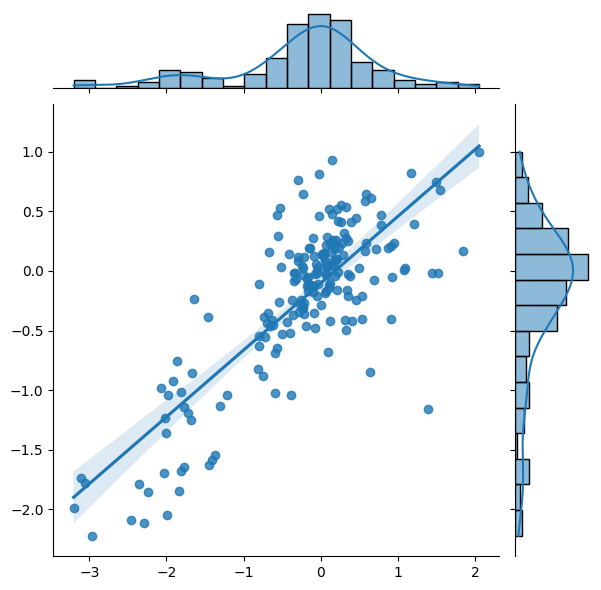

In [ ]:
sns.jointplot(x=true, y =pred, kind='reg')
plt.show()

## Модель CGCNN_Geometric_optimized

In [18]:
class CGCNN_Geometric_optimized(nn.Module):
    def __init__(self, num_node_features, hidden_dim=64, num_hidden_layers=2):
        super(CGCNN_Geometric_optimized, self).__init__()
        
        self.embedding = nn.Linear(num_node_features, hidden_dim)

        self.conv1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.act1 = nn.Softplus()

        self.hidden_layers = nn.Sequential()
        for i in range(num_hidden_layers):
            self.hidden_layers.add_module(f'fc_{i}', nn.Linear(hidden_dim, hidden_dim))
            self.hidden_layers.add_module(f'act_{i}', nn.Softplus())

        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # В этом CGCNN нет геометрии связи, так что мы сделаем аналог простой агрегации
        x = self.embedding(x)  # [num_nodes, hidden_dim]

        # Простейший псевдо-конволюционный шаг:
        row, col = edge_index
        edge_msg = torch.cat([x[row], x[col]], dim=1)  # [num_edges, hidden_dim * 2]
        agg = self.conv1(edge_msg)  # [num_edges, hidden_dim]
        agg = self.bn1(agg)
        agg = self.act1(agg)

        # Суммируем по каждому узлу входящие сообщения
        node_msg = torch.zeros_like(x)
        node_msg.index_add_(0, row, agg)
        x = x + node_msg  # residual

        # Pooling на уровне кристалла
        crys_fea = global_mean_pool(x, batch)  # [batch_size, hidden_dim]

        # Прогон через MLP
        crys_fea = self.hidden_layers(crys_fea)

        # Выход
        out = self.fc_out(crys_fea)  # [batch_size, 1]
        return out

### Initiating the model / Инициируем модель

In [ ]:
# # import modules
# from models.GNN_first import GCN

In [19]:
# defining hyperparameters / определяем гиперпараметры 
hyperparameters = {'hidden_embeding':128, 'num_node_features': dataset.num_node_features}

In [22]:
# инициируем модель 
# model = CGCNN_Geometric_optimized(hyperparameters=hyperparameters,)
# TypeError: CGCNN_Geometric_optimized.__init__() got an unexpected keyword argument 'hyperparameters'

In [ ]:
# смотрим параметр количество признаков в узле
dataset.num_node_features

5

In [50]:
# создаём модель
model_CGCNN_Geometric_optimized = CGCNN_Geometric_optimized(num_node_features=hyperparameters['num_node_features'],
                        hidden_dim=hyperparameters['hidden_embeding'])

In [51]:
# смотрим на модель ещё раз
model_CGCNN_Geometric_optimized

CGCNN_Geometric_optimized(
  (embedding): Linear(in_features=5, out_features=128, bias=True)
  (conv1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Softplus(beta=1, threshold=20)
  (hidden_layers): Sequential(
    (fc_0): Linear(in_features=128, out_features=128, bias=True)
    (act_0): Softplus(beta=1, threshold=20)
    (fc_1): Linear(in_features=128, out_features=128, bias=True)
    (act_1): Softplus(beta=1, threshold=20)
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
CGCNN_Geometric_optimized

__main__.CGCNN_Geometric_optimized

In [ ]:
# # defining hyperparameters / определяем гиперпараметры 
# hyperparameters = {'hidden_embeding':128, 'num_node_features': dataset.num_node_features}

# # инициируем модель 
# model = GCN(hyperparameters=hyperparameters,)

детальное описание каждого компонента модели `CGCNN_Geometric_optimized`:

---

  **1. Входной слой (`embedding`)**
```python
(embedding): Linear(in_features=5, out_features=128, bias=True)
```
- **Назначение**: Преобразует исходные атомные признаки в скрытое пространство.
- **Параметры**:
  - `in_features=5`: Размер входных атомных признаков (например: атомный номер, координаты, заряд).
  - `out_features=128`: Размер скрытого представления (эмбеддинга) атома.
  - `bias=True`: Использование смещения (байас) в линейном преобразовании.

---

  **2. Графовая свертка (`conv1`)**
```python
(conv1): Linear(in_features=256, out_features=128, bias=True)
```
- **Назначение**: Агрегирует информацию от соседних атомов (комбинация признаков центрального атома и его соседей).
- **Параметры**:
  - `in_features=256`: 
    - 128 (признаки центрального атома) + 128 (признаки соседа) = 256.
  - `out_features=128`: Размер выходного признакового пространства после свертки.

---

  **3. Нормализация (`bn1`)**
```python
(bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
```
- **Назначение**: Стабилизирует обучение через нормализацию активаций.
- **Параметры**:
  - `num_features=128`: Число признаков для нормализации.
  - `eps=1e-05`: Малое число для численной стабильности.
  - `momentum=0.1`: Коэффициент для скользящего среднего.
  - `affine=True`: Наличие обучаемых параметров масштаба и сдвига.
  - `track_running_stats=True`: Обновление статистик (среднее/дисперсия) во время обучения.

---

  **4. Функция активации (`act1`)**
```python
(act1): Softplus(beta=1, threshold=20)
```
- **Назначение**: Нелинейное преобразование (альтернатива ReLU).
- **Параметры**:
  - `beta=1`: Коэффициент крутизны.
  - `threshold=20`: При значениях >20 используется линейная аппроксимация для численной стабильности.

---

  **5. Скрытые слои (`hidden_layers`)**
```python
(hidden_layers): Sequential(
  (fc_0): Linear(in_features=128, out_features=128, bias=True)
  (act_0): Softplus(beta=1, threshold=20)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (act_1): Softplus(beta=1, threshold=20)
)
```
- **Назначение**: Углубленное преобразование признаков.
- **Структура**:
  - **Линейный слой** (`fc_0`, `fc_1`): 
    - `in_features=128`, `out_features=128` (сохранение размерности).
  - **Активация** (`act_0`, `act_1`): Аналогична `act1`.

---

  **6. Выходной слой (`fc_out`)**
```python
(fc_out): Linear(in_features=128, out_features=1, bias=True)
```
- **Назначение**: Финалное предсказание (например, энергии образования).
- **Параметры**:
  - `in_features=128`: Размер входных признаков.
  - `out_features=1`: Выход модели (скаляр для регрессии).

---

 **7. Дополнительные детали архитектуры**
1. **Отсутствие пулинга**: Вероятно, используется глобальный пулинг (например, `global_mean_pool`) вне класса.
2. **Отсутствие dropout**: Нет регуляризации, что может привести к переобучению на малых датасетах.
3. **Выбор активации**: `Softplus` вместо ReLU для плавных градиентов (важно для регрессии).

---

  **8. Как улучшить модель?**
1. **Регуляризация**:
   ```python
   nn.Dropout(p=0.3)  # Добавить после активаций
   ```
2. **Расширение признаков**:
   ```python
   embedding = Linear(in_features=10, out_features=256)  # Больше входных признаков
   ```
3. **Усложнение архитектуры**:
   ```python
   self.conv2 = Linear(256, 128)  # Добавить вторую свертку
   ```

---

  **Пример forward-pass**
```python
def forward(self, data):
    x, edge_index = data.x, data.edge_index
    
    # 1. Atom embedding
    x = self.embedding(x)  # [N_atoms, 5] -> [N_atoms, 128]
    
    # 2. Graph convolution
    row, col = edge_index
    x = torch.cat([x[row], x[col]], dim=1)  # [N_edges, 256]
    x = self.conv1(x)  # [N_edges, 128]
    x = self.bn1(x)
    x = self.act1(x)
    
    # 3. Hidden layers
    x = self.hidden_layers(x)  # [N_edges, 128]
    
    # 4. Global pooling + output
    x = global_mean_pool(x, data.batch)  # [N_graphs, 128]
    return self.fc_out(x)  # [N_graphs, 1]
```

Эта архитектура оптимальна для задач регрессии свойств материалов, но требует тонкой настройки гиперпараметров для конкретных датасетов.

### Optimizer and loss function / Оптимизатор и функция потерь

In [52]:
# создание оптимизатора Adam для обучения нейронной сети. Оптимизатор отвечает за обновление весов модели в процессе обучения.
optimizer_for_CGCNN_Geometric_optimized = torch.optim.Adam(model_CGCNN_Geometric_optimized.parameters(), lr=0.001)

In [53]:
# добавил самостоятельно, насколько это тут необходимо пока не совсем понимаю
criterion_for_CGCNN_Geometric_optimized = torch.nn.MSELoss()

### Model launch function / Функция запуска модели

In [56]:
n=0
for data in train_loader:
    print(n)
    n+=1

0
1
2
3
4


In [57]:
data

DataBatch(x=[1456, 5], y=[44, 1], pos=[1456, 3], lattice=[44, 9], edge_index=[2, 8736], batch=[1456], ptr=[45])

In [58]:
out = model_CGCNN_Geometric_optimized(data)

In [60]:
len(out)

44

In [ ]:
def run_model_CGCNN_Geometric_optimized(model, epochs, train_loader, test_loader):
    """
    Основная функция для обучения и оценки модели.
    
    Параметры:
        model (torch.nn.Module): Нейронная сеть для обучения
        epochs (int): Количество эпох обучения
        train_loader (torch_geometric.loader.DataLoader): Загрузчик тренировочных данных
        test_loader (torch_geometric.loader.DataLoader): Загрузчик тестовых данных
    """
    
    def train():
        """
        Внутренняя функция для одной эпохи обучения.
        Возвращает суммарный лосс за эпоху.
        """
        # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
        model.train()
        val_loss = 0  # Инициализируем переменную для накопления лосса

        # Итерируемся по батчам тренировочных данных
        for data in train_loader:
            # 1. Прямой проход (forward pass) - вычисление предсказаний модели
            out = model_CGCNN_Geometric_optimized(data)

            # 2. Вычисление функции потерь между предсказаниями и истинными значениями
            loss = criterion_for_CGCNN_Geometric_optimized(out, data['y'])

            # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
            loss.backward()

            # 4. Обновление параметров модели на основе вычисленных градиентов
            optimizer_for_CGCNN_Geometric_optimized.step()

            # 5. Обнуление градиентов перед следующим батчем
            optimizer_for_CGCNN_Geometric_optimized.zero_grad()

            # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
            val_loss += loss.detach().item()

        return val_loss  # Возвращаем суммарный лосс за эпоху


    def test(loader):
        """
        Внутренняя функция для оценки модели на переданном загрузчике данных.
        Возвращает среднее значение R2-score по всем батчам.
        """
        # Переводим модель в режим оценки (отключаем Dropout и т.д.)
        model.eval()
        r2 = []  # Список для хранения R2-score по каждому батчу

        # Итерируемся по батчам данных (без вычисления градиентов)
        for data in loader:
            # Получаем предсказания модели
            out = model(data)

            # Преобразуем предсказания и истинные значения в 1D массивы
            pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
            true = data['y'].ravel()

            # Вычисляем R2-score для текущего батча и сохраняем
            r2.append(r2_score(pred.numpy(), true.numpy()))

        # Возвращаем среднее значение R2-score по всем батчам
        return np.array(r2).mean()

    # Основной цикл обучения
    for epoch in range(1, epochs+1):
        # Одна эпоха обучения и получение лосса
        val_loss = train()
        
        # Вывод информации о текущей эпохе
        print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

        # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
        if epoch % 10 == 0:
            train_acc = test(train_loader)  # R2 на тренировочных данных
            test_acc = test(test_loader)   # R2 на тестовых данных
            print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

### Launching training and testing of the model / Запуск обучения и тестирования модели

In [28]:
run_model(model, 60, train_loader, test_loader)

Epoch: 001, Val Loss: 8.9456
Epoch: 002, Val Loss: 7.5521
Epoch: 003, Val Loss: 6.4685
Epoch: 004, Val Loss: 5.7058
Epoch: 005, Val Loss: 5.6715
Epoch: 006, Val Loss: 5.2743
Epoch: 007, Val Loss: 5.1272
Epoch: 008, Val Loss: 5.2911
Epoch: 009, Val Loss: 4.4142
Epoch: 010, Val Loss: 4.2376
Train R2: -3.1376, Test R2: -4.0952
Epoch: 011, Val Loss: 4.0310
Epoch: 012, Val Loss: 4.5955
Epoch: 013, Val Loss: 4.3582
Epoch: 014, Val Loss: 3.9314
Epoch: 015, Val Loss: 3.6568
Epoch: 016, Val Loss: 3.7845
Epoch: 017, Val Loss: 3.7981
Epoch: 018, Val Loss: 3.8935
Epoch: 019, Val Loss: 4.0847
Epoch: 020, Val Loss: 3.7489
Train R2: -1.6995, Test R2: -2.0859
Epoch: 021, Val Loss: 3.5705
Epoch: 022, Val Loss: 3.3303
Epoch: 023, Val Loss: 3.2101
Epoch: 024, Val Loss: 3.4058
Epoch: 025, Val Loss: 3.3733
Epoch: 026, Val Loss: 3.1419
Epoch: 027, Val Loss: 2.9441
Epoch: 028, Val Loss: 2.9754
Epoch: 029, Val Loss: 2.8615
Epoch: 030, Val Loss: 2.8355
Train R2: -0.5235, Test R2: -0.5293
Epoch: 031, Val Loss: 

### Graph Model Evaluation / Оценка графической модели

In [29]:
model.eval()

test_loader = DataLoader_geometric(test_dataset, batch_size=1)

pred, true = [], []
for data in test_loader:
    out = model(data)
    pred.append(out.item())
    true.append(data.y.item())

len(pred), len(true)

(189, 189)

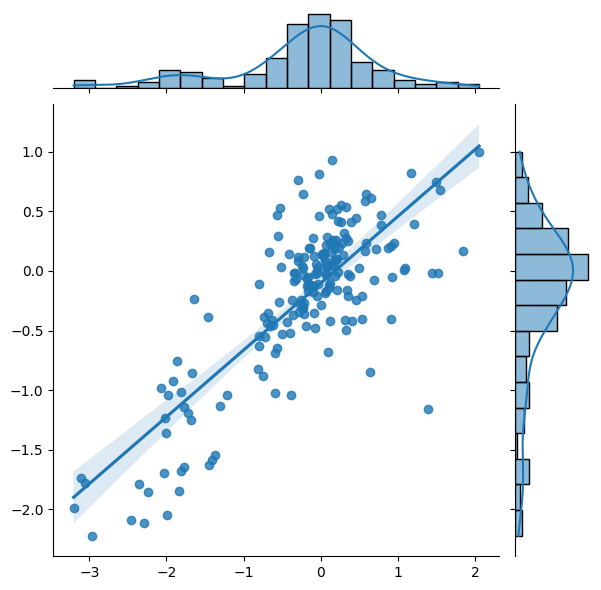

In [30]:
sns.jointplot(x=true, y =pred, kind='reg')
plt.show()

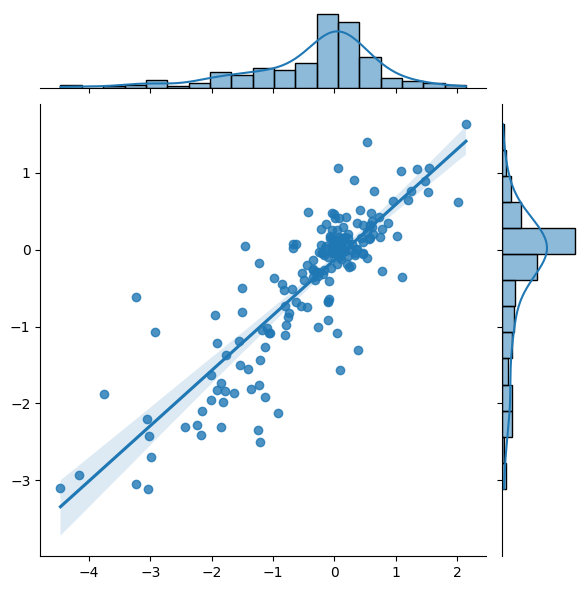

In [ ]:
# sns.jointplot(x=true, y =pred, kind='reg')
# plt.show()

In [31]:
r2_score(pred, true), mean_absolute_error(pred, true)

(0.24612240021346943, 0.4034583116832273)

In [26]:
r2_score(pred, true), mean_absolute_error(pred, true)

(0.6184309666857655, 0.38390395455505877)

## Saving the result to a table / Сохраним результат в таблицу

В таблице сохраним дату и время, название модели, прогнозируемая величина, название папки с данными, информация о %train, показатель r2, показатель MAE, комментарии.

In [52]:
# созданим датафрейм
df_results = pd.DataFrame(columns=['Date', 'Model', 'Predicted_property', 'Name_data_folder', '%_train', 'Train_R2', 'Test_R2', 'Test_MAE', 'Comments'])

In [49]:
str(date.today())

'2025-04-02'

In [53]:
# добавляем данные в датафрейм
df_results.loc[len(df_results)] = \
    [str(date.today()),
     'from models.GNN_first import GCN',
     'Formation_energy (eV/atom)',
     'data/graphs_structures_Fm_3m',
     '15%',
     0.8216,
     0.6184,
     0.383903,
     'First predict in this project'
     ]

In [ ]:
# смотрим таблицу
df_results

,Date,Model,Predicted_property,Name_data_folder,%_train,Train_R2,Test_R2,Test_MAE,Comments
0,2025-04-02,from models.GNN_first import GCN,Formation_energy (eV/atom),data/graphs_structures_Fm_3m,15%,0.8216,0.6184,0.383903,First predict in this project


In [55]:
# записываем датафрейм
PATH_FOR_SAVE = './results/df_results.xlsx'
df_results.to_excel(PATH_FOR_SAVE, index=False)

## **Project results / Вывод по проекту: "Предсказание энергии образования кристаллов с помощью GNN"**  

### **Архитектура модели GNN для предсказания энергии образования кристаллов**

Применяемая модель представляет собой **графовую нейронную сеть (GNN)**, специально разработанную для анализа кристаллических структур и предсказания их энергии образования. Она сочетает обработку локальных атомных взаимодействий и глобальных параметров кристаллической решётки.  

---

#### **1. Входные данные**  
Модель принимает на вход **графы кристаллических структур**, где:  
- **Узлы** — атомы с их свойствами (атомный номер, молярный объём, электроотрицательность и др.).  
- **Рёбра** — химические связи между атомами, заданные через `edge_index`.  
- **Глобальные параметры** — тензор с параметрами кристаллической решётки (3×3 матрица в виде вектора из 9 элементов).  

---

#### **2. Основные компоненты архитектуры**

1. **Структурный эмбеддинг (PointTransformerConv)**  
   - Преобразует **атомные признаки** и их **геометрическое расположение** (координаты) в векторные представления.  
   - Учитывает связи между атомами (`edge_index`) и их пространственную близость (`pos`).  
   - Аналогичен механизму внимания (attention), но оптимизирован для материаловедческих задач.  

2. **Глобальное усреднение (Global Mean Pooling)**  
   - Агрегирует атомные эмбеддинги в **единый вектор** для всей кристаллической структуры.  
   - Позволяет модели работать с кристаллами разного размера.  

3. **Эмбеддинг решётки (Linear)**  
   - Кодирует **параметры кристаллической решётки** (периодичность ячейки) в скрытое пространство той же размерности, что и структурные признаки.  

4. **Объединение признаков**  
   - Вектор структурных признаков (после pooling) и вектор решётки объединяются в **один дескриптор кристалла**.  

5. **Полносвязные слои (MLP)**  
   - Каскад линейных слоёв с активацией ReLU:  
     - Уменьшает размерность объединённого вектора.  
     - Выявляет нелинейные зависимости между структурой и энергией.  

6. **Выходной слой (Linear)**  
   - Фиксирует результат в виде **скалярного значения** — предсказанной энергии образования.  

---

#### **3. Особенности архитектуры**  
- **Гибкость**: Может обрабатывать кристаллы с произвольным числом атомов благодаря механизму pooling.  
- **Учёт геометрии**: PointTransformerConv явно использует координаты атомов, что критично для материаловедения.  
- **Комбинация признаков**: Совмещает **локальные** (атомные) и **глобальные** (решёточные) свойства.  

---

#### **4. Ограничения и возможные улучшения**  
- **Нет учёта углов** между связями (можно добавить SchNet или DimeNet++).  
- **Отсутствие регуляризации** (например, Dropout) — может привести к переобучению на малых датасетах.  
- **Зависимость от качества графов**: Точность предсказаний сильно зависит от способа построения графа (например, выбора радиуса обрезания связей).  

---

#### **5. Практическое применение**  
Модель подходит для:  
- Быстрого скрининга стабильных кристаллических структур.  
- Предсказания свойств материалов без дорогостоящих квантово-химических расчётов.  
- Сравнительного анализа разных классов соединений (например, сплавов с одинаковой пространственной группой).  

Эта архитектура — **базовый, но эффективный инструмент** для задач материаловедения, который можно дорабатывать под конкретные требования.

### **Основные достижения**  
Проект успешно демонстрирует применение **графовых нейронных сетей (GNN)** для предсказания энергии образования кристаллических структур на данных из **Materials Project**. Ключевые результаты:  
- **Качество модели**:  
  - **Train R² = 0.8216**, **Test R² = 0.6184** — модель хорошо обучается, но есть риск переобучения (разница между train и test).  
  - Для улучшения можно добавить регуляризацию (Dropout, L2) или увеличить датасет.  
- **Архитектура**:  
  - Использован **PointTransformerConv** для учёта геометрии кристаллов + полносвязные слои.  
  - Учтены **параметры решётки** (lattice) — важный вклад в материаловедение.  

#### **Ограничения и пути улучшения**  
- **Данные**:  
  - Только структуры с **пространственной группой Fm-3m** (1257 образцов) — для более общих выводов нужны разнообразные данные.  
  - Нет проверки на мультикомпонентных системах (сплавы, оксиды).  
- **Модель**:  
  - Нет кросс-валидации — результаты могут быть нестабильными.  
  - Можно протестировать другие архитектуры (**CGCNN, MEGNet, ALIGNN**).  
- **Интерпретируемость**:  
  - Не анализируется, какие **атомные свойства** или **типы связей** влияют на энергию.  

#### **Практическая ценность**  
- **Для материаловедения**:  
  - Метод позволяет быстро предсказывать энергию образования без DFT-расчётов.  
  - Может использоваться для скрининга стабильных материалов.  
- **Для ML-инженеров**:  
  - Чёткий пайплайн: от данных до обучения GNN.  
  - Пример работы с **PyTorch Geometric** для кристаллов.  

#### **Рекомендации**  
1. **Расширить датасет**:  
   - Добавить другие пространственные группы и химические элементы.  
2. **Улучшить модель**:  
   - Добавить **BatchNorm** и **Dropout**.  
   - Протестировать **перекрёстную проверку**.  
3. **Визуализировать результаты**:  
   - Построить графики **зависимости ошибки от свойств кристаллов**.  
   - Использовать **GNNExplainer** для интерпретации.  

### **Итог**  
Проект служит **практическим руководством** по применению GNN в материаловедении. Для production-решения потребуется доработка, но текущая версия уже полезна для исследовательских целей.  

**Следующие возможные шаги**:  
- Добавить мультитаргетное предсказание (энергия + ширина зоны).  
- Реализовать **генерацию новых структур** с помощью GNN.